### **社群媒體分析第二次讀書會：對ptt上此次核能公投的議題分析::**

---
第二組

組員：M094050010 龔紫雲、M104020004 鍾君右、M104020031 周駿嚴、M104020038 蕭清耀、M104020014 周紘樟、B074020058 曾天鈞

指導老師：黃三益 教授

### **基於核四公投為最近台灣較為熱門的討論議題之一, 因此作為此次社群分析之目標。**
### **而分析主要著重在ptt上民眾對核四公投看法的討論議題, 分析面向如下：**

**1**.**PTT上，對核四公投發表意見的對象有哪些，民眾的討論重點為何**?: NER抓出特定實體，POS詞性辨識找出關鍵字分析，查看相關推文、關鍵字

**2.PTT上討論核四公投之情緒分布的趨勢如何，正面和負面的文章主要的討論焦點、討論內容各是什麼**，並使用SnowNLP情緒分析去推測文章中句子的正負情緒，結合文字雲、關鍵字找出相關討論事件

**3.分析PTT上之核四公投議題，相關文章的詞彙關係**，目的為透過TF-IDF, N-gram等方法找出文章以及字詞間的關聯，並使用Bigram視覺化與計算文章的相似度

**4.字詞分類**，將ptt八卦版與政黑版蒐集之文章，利用liwc字典計算情緒分數，分為正面、中性、負面三種標籤，再用線性模型進行文件的情緒分類，最後比較不同模型和資料組合的訓練結果

## **大綱**
- ### **情緒分析**
  1.載入套件

  2.CKIP 標註

      2.1 斷詞(WS)
      2.2 實體辨識(Ner)
      2.3 詞性標注(Pos)

   3.Snow NLP 情緒分析

- ### **文辭和文件分析**
  1.TF-IDF  
  2.N-gram預測模型 & Bigram視覺化   
  3.詞彙相關分析   
  4.文章相似度分析

- ### **文件分類**
  1.資料前處理    
  2.測試集和訓練集的資料切分    
  3.將文章轉為DTM放入模型訓練     
  4.比較不同模型和資料組合的預測結果


## 情緒分析



**1.套件說明**

下面列出在本次實作過程中我們所使用到的相關套件，在這個Jupyter Notebook當中我們將會簡單的展示這些套件的使用方式，關於各個套件的進階使用請同學參照其官網的說明。

pandas: 一個資料分析的函式庫，提供了DataFrame等資料格式，與資料處理的函數。

CKIP: 全名為Chinese Knowledge and Information Processing，中研院開發的中文自然語言處理工具。

stanza: 使用CoreNLP的官方套件

wordcloud: 文字雲繪圖工具。

matplotlib: 繪圖工具。

SnowNLP: SnowNLP是一個可以方便的處理中文文本內容的python類庫，是受到了TextBlob的啟發而寫的。SnowNLP主要功能包括斷詞、詞性標註、情緒分析、漢字轉拼音、繁體轉簡體、關鍵詞提取以及文本摘要等等。

In [ ]:
%pip install ckiptagger[tf,gdown] wordcloud tweepy==3.10.0 SnowNLP

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from ckiptagger import data_utils, construct_dictionary, WS, POS, NER
import configparser, re, os, io

from wordcloud import WordCloud, ImageColorGenerator
import tweepy as tw
import matplotlib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from datetime import datetime, timedelta

In [ ]:
%pwd

'/content/drive/My Drive/ColabNotebooks/Colab_Notebooks_study/公投'

In [ ]:
%cd ./drive/MyDrive/ColabNotebooks/Colab_Notebooks_study/公投

[Errno 2] No such file or directory: './drive/MyDrive/ColabNotebooks/Colab_Notebooks_study/公投'
/content/drive/MyDrive/ColabNotebooks/Colab_Notebooks_study/公投


      2.2. CKIP:是中研院詞庫小組開發的中文自然語言處理套件，其斷詞效果比起jieba效果更好，並且提供性命名實體辨識、詞性標註、句法分析，以下為CKIP安裝步驟。

In [ ]:
data_utils.download_data_gdown("./") # gdrive-ckip # 下載ckip model

Permission denied: https://drive.google.com/uc?id=1efHsY16pxK0lBD2gYCgCTnv1Swstq771
Maybe you need to change permission over 'Anyone with the link'?


In [ ]:
# To use CPU:
ws = WS("./data")
pos = POS("./data")
ner = NER("./data")

/usr/local/lib/python3.7/dist-packages/ckiptagger/model_ws.py:106: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.compat.v1.nn.rnn_cell.LSTMCell(hidden_d, name=name)
/usr/local/lib/python3.7/dist-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:988: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  partitioner=maybe_partitioner)
/usr/local/lib/python3.7/dist-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:996: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  initializer=initializer)
/usr/local/lib/python3.7/dist-packages/ckiptagger/model_pos.py:56: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class

In [ ]:
# 讀取已經抓取完成的貼文
MetaData = pd.read_csv("/content/drive/MyDrive/ColabNotebooks/Colab_Notebooks_study/公投/公投rawdata政黑/PTT_核四Politics_articleMetaData.csv")
MetaData

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence
0,[新聞]中國忌憚美英澳核潛艇合作王毅：五重危,2021/10/01,01:02:45,https://www.ptt.cc/bbs/HatePolitics/M.16330501...,starport,HatePolitics,11,5,1,中國忌憚美英澳核潛艇合作 王毅：五重危害\nhttps://bit.ly/3A9dm2d\n...
1,[轉錄]中正紀念堂銅像拆了以後要放什麼？,2021/10/01,06:24:44,https://www.ptt.cc/bbs/HatePolitics/M.16330694...,twoquarters,HatePolitics,20,8,1,1.轉錄網址：\nhttps://bit.ly/39WjFvk\n2.轉錄來源︰\nThe ...
2,[新聞]1個月停電3次!陳其邁震怒批台電「落漆」,2021/10/01,10:52:49,https://www.ptt.cc/bbs/HatePolitics/M.16330855...,jason486,HatePolitics,9,6,0,1個月停電3次!陳其邁震怒批台電「落漆」 黃捷:鳳山民怨已深\n\n新頭殼newtalk |...
3,Re:[討論]藍白營會跟著中國經濟下去了吧,2021/10/01,18:06:13,https://www.ptt.cc/bbs/HatePolitics/M.16331115...,microsugar,HatePolitics,13,4,2,你以為你是誰啊，少往臉上貼金\n嗆你沒種回文，你也不想想你紮紮實實沒種了幾次\n然後呢，在政...
4,[討論]中國漲電價下大棋了,2021/10/02,03:53:01,https://www.ptt.cc/bbs/HatePolitics/M.16331467...,homeaki,HatePolitics,7,5,0,中國多地傳出限電 電網崩潰理論\nhttps://i.imgur.com/zUytsZN.j...
...,...,...,...,...,...,...,...,...,...,...
2038,Re:[討論]朱宅神是不是急了阿?,2021/11/29,15:27:53,https://www.ptt.cc/bbs/HatePolitics/M.16381996...,myIDis7,HatePolitics,10,4,1,職?\n根\n…這咖的話你也在分析？\n\n成衣商就只是蹭熱度專家\n\n風往哪邊吹就往哪邊...
2039,[轉錄]我的同意票拒絕萊豬的食安風險,2021/11/29,15:29:51,https://www.ptt.cc/bbs/HatePolitics/M.16381997...,GV13,HatePolitics,40,2,17,1.轉錄網址︰\nhttps://udn.com/news/story/7339/59234...
2040,[轉錄]用公投表態走出缺電與漲價困境,2021/11/29,15:36:11,https://www.ptt.cc/bbs/HatePolitics/M.16382001...,GV13,HatePolitics,4,1,1,1.轉錄網址︰\nhttps://udn.com/news/story/7339/59234...
2041,[討論]疫情是不是又有爆發的節奏???,2021/11/29,15:37:48,https://www.ptt.cc/bbs/HatePolitics/M.16382002...,eddisontw,HatePolitics,13,8,1,才剛宣布邊境要放寬7+7\n然後就傳出南非出現變種病毒\n然後擴散歐洲各國\n今天也出現機師...


In [ ]:
keywords = ['核四','核能','核廢料','重啟核四','無核家園','以核養綠','綠色和平','非核家園']
toMatch = '|'.join(keywords)
MetaData = MetaData.loc[MetaData['sentence'].str.contains(toMatch) | MetaData['artTitle'].str.contains(toMatch), :]
MetaData.reset_index(inplace=True, drop=True) #重設index
MetaData

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence
0,[新聞]中國忌憚美英澳核潛艇合作王毅：五重危,2021/10/01,01:02:45,https://www.ptt.cc/bbs/HatePolitics/M.16330501...,starport,HatePolitics,11,5,1,中國忌憚美英澳核潛艇合作 王毅：五重危害\nhttps://bit.ly/3A9dm2d\n...
1,[黑特]誰能告訴我反對核四的理由到底是什麼,2021/10/05,07:55:34,https://www.ptt.cc/bbs/HatePolitics/M.16334205...,nobody0303,HatePolitics,26,2,3,這個世界這麼多地震天災人禍\n去探討極小機率會發生的重大災難\n根本一點意義都沒有\n問題是...
2,Re:[黑特]誰能告訴我反對核四的理由到底是什麼,2021/10/05,09:10:27,https://www.ptt.cc/bbs/HatePolitics/M.16334250...,loser1,HatePolitics,34,9,6,因為一開始就是為了核四而核四，\n四十年前蔣經國就把他給暫停了，\n然後好伯村又拿出來當政見...
3,Re:[黑特]誰能告訴我反對核四的理由到底是什麼,2021/10/05,09:56:45,https://www.ptt.cc/bbs/HatePolitics/M.16334278...,twnndnpdnc,HatePolitics,2,0,0,其實不用說這麼複雜\n\n若是你偏綠反核\n想要堵偏藍擁核的嘴\n你就說\n華人社會最繁華的...
4,Re:[黑特]誰能告訴我反對核四的理由到底是什麼,2021/10/05,10:38:42,https://www.ptt.cc/bbs/HatePolitics/M.16334303...,chen740530,HatePolitics,14,5,0,核能電廠有保存期限 核電廠的空間等於壽命\n\n因為要擺放高階核廢料\n\n核一二三廠會達使...
...,...,...,...,...,...,...,...,...,...,...
1092,Re:[討論]這次公投怎麼投應該很簡單吧？,2021/11/29,10:11:45,https://www.ptt.cc/bbs/HatePolitics/M.16381807...,ff704,HatePolitics,14,2,3,台灣豬都不吃，台灣人當然不吃\n支持三接，藻礁根本醜，無感\n當然綁，嫌政府錢太多喔\n台灣...
1093,Re:[討論]民眾黨應該延攬有戰力的黃士修選台北市,2021/11/29,11:10:59,https://www.ptt.cc/bbs/HatePolitics/M.16381842...,neverfly,HatePolitics,1,0,1,"其實真的很適合啊，\n想像一下對話就知道：\n\n""那些就是貪婪的老人，貪1500的敬老金，..."
1094,[新聞]美國前能源部長呼籲延役加州惡魔谷核電廠,2021/11/29,13:35:19,https://www.ptt.cc/bbs/HatePolitics/M.16381929...,NARUTO,HatePolitics,38,10,5,1.新聞網址︰\nhttps://www.chinatimes.com/realtimene...
1095,Re:[討論]朱宅神是不是急了阿?,2021/11/29,15:27:53,https://www.ptt.cc/bbs/HatePolitics/M.16381996...,myIDis7,HatePolitics,10,4,1,職?\n根\n…這咖的話你也在分析？\n\n成衣商就只是蹭熱度專家\n\n風往哪邊吹就往哪邊...


    將抓取結果，實做一次將該資料使用coreNLP進行自然語言處理， 以下為定義文字清理的相關function

In [ ]:
def Segmentation_Core(data, tokenizer):
    # 將所有的斷行字元配上 escape 以防失效
    regexPattern = '|'.join(map(re.escape, tokenizer))
    output_list = re.split(regexPattern, data)
    # 過濾空白行
    output_list = list(filter(None, output_list))
    return output_list

def Sentence_Segmentation(article, keep_digits=False, keep_alphabets=False):
    """ Sentence_Segmentation function 用於執行中文斷行任務

    順序如下：
    1. 去除(\\n)
    2. 去除特殊符號字元
    3. 保留數字
    4. 依照斷句字元進行斷句全形的分號、逗號、句號、問號以及驚嘆號
    5. 避免空白斷句結果

    Args:
        article(string): 欲斷行之文章內容
        keep_digits(Boolean): 決定是否保留數字於斷行後的結果
        keep_alphabets(Boolean): 決定是否保留字母於斷行後的結果
    Returns:
        List [] 每個 element 就是一行
    """
    final_res = []
    sepical_symbols = r'[.＂<>:《》+\-=#$%&()*@＃＄％＆＇\(\)\[\]\{\}（）＊＋－／：\
    ＜＝＞＠［＼］＾＿｀｛｜｝～｟｠｢｣､、〃》「」『』【】〔〕〖〗〘〙〚〛〜〝〞〟〰〾〿–—‘’‛“”„‟…‧﹏★→─]+'
    segmentation_used_note = (";", "；", "！", "!", "？", "?", "。")
    
#     paragraphs = list(filter(None, article.split("\n")))
    paragraphs = list(filter(lambda x: re.sub(r'\s+','', x), article.split("\n")))
#     print(len(paragraphs))
#     print(paragraphs)
    result = []
    for paragraph in paragraphs:

        clean_paragraph = paragraph
        try:
            if not keep_digits:
                clean_paragraph = re.sub(r'\d*\.?\d+','', clean_paragraph) #remove space & digits
            if not keep_alphabets:
                clean_paragraph = re.sub('[a-zA-Z]+', '', clean_paragraph)
            
            clean_paragraph = re.sub(r'[\s]+','', clean_paragraph) #remove space
            
            clean_paragraph = re.sub(sepical_symbols,'',clean_paragraph)
            
        except:
            _logger.info("error")
            return "error"
        
        res = Segmentation_Core(clean_paragraph, segmentation_used_note)
        result.append(res)
    
    return result

    CKIP設定 : 讀入自定義的核能公投辭典。

In [ ]:
# 自定義辭典
with open('/content/drive/MyDrive/ColabNotebooks/Colab_Notebooks_study/公投/文件分析dict/核能.txt') as f:
    lines = f.read().splitlines()

dict_harry = {k: 1 for v, k in enumerate(lines)}
dictionary2 = construct_dictionary(dict_harry)
print(dictionary2)

[(2, {'核四': 1.0, '核電': 1.0, '核安': 1.0, '公投': 1.0, '重啟': 1.0, '台電': 1.0, '缺電': 1.0, '電價': 1.0}), (3, {'核廢料': 1.0, '拼裝車': 1.0, '黃士修': 1.0, '蔡英文': 1.0, '民進黨': 1.0, '國民黨': 1.0}), (4, {'以核養綠': 1.0, '綠色和平': 1.0, '非核家園': 1.0})]


    計算實體辨識（ner）詞性標註（pos)之內容

In [ ]:
def get_pos(post_id, word_sentence, pos_sentence):
    tokens = []
#     print("\nPOS: ", end="\u3000")
    assert len(word_sentence) == len(pos_sentence)
    for word, pos in zip(word_sentence, pos_sentence): # token level
        tokens.append([post_id,word,pos]) 
#         print(f"{word}({pos})", end="\u3000")
    return tokens

def get_ner(post_id, entity_sentence):
    entities = []
#     print("\nNER:___________ ")
    for entity in sorted(entity_sentence): # token level
        entities.append([post_id, entity[3],entity[2]]) 
    return entities

def get_nlp_result(data_df):
    start = time.time()

    pos_list = []
    entity_list = []
    sentence_list = []
    
    for index, row in data_df.iterrows(): # document level    
#         print(f"\ndocument {index}") 

        # clean data
        result = [] 
        tmp = Sentence_Segmentation(row['sentence']) 
        flat_list = [item for sublist in tmp for item in sublist]

        # ckip
        word_sentence_list = ws(flat_list, coerce_dictionary = dictionary2) # set dictionary 
        pos_sentence_list = pos(word_sentence_list)
        entity_sentence_list = ner(word_sentence_list, pos_sentence_list)

        for i, sentence in enumerate(flat_list): # sentence level
#             print(f"sentence {i}: {sentence}")
            sentence_list.append([row['artDate'],sentence])            
            temp_tokens = get_pos(row['artDate'],word_sentence_list[i],  pos_sentence_list[i])
            temp_entites = get_ner(row['artDate'],entity_sentence_list[i])

            pos_list.append(temp_tokens)
            if len(temp_entites) != 0:
                entity_list.append(temp_entites)
            
    pos_flat = [item for sublist in pos_list for item in sublist]
    entity_flat = [item for sublist in entity_list for item in sublist]

    pos_table = pd.DataFrame(data=pos_flat, 
                    columns=['artDate','word','pos'])        
    
    entity_table = pd.DataFrame(data=entity_flat, 
                        columns=['artDate','word','ner']) 

    sentence_table = pd.DataFrame(data=sentence_list, 
                    columns=['artDate','sentence']) 

    end = time.time()
    print("time costing: {}".format(end - start))

    return pos_table, entity_table, sentence_table

In [ ]:
#pos_table, entity_table, sentence_table = get_nlp_result(MetaData)

In [ ]:
#pos_table.head(5) # word pos 列表

In [ ]:
#entity_table.head(5) # word entity 列表

In [ ]:
# 檢查筆數正不正確
#print(f"total posts numbers: {len(pos_table['artDate'].unique())}") # 636篇文
#print(f"posts have NER: {len(entity_table['artDate'].unique())}") # 440篇有抓到ner

In [ ]:
#pos_table.to_csv(r'/pos_table_核四.csv', index = False)
#entity_table.to_csv(r'/entity_table_核四.csv', index = False)
#sentence_table.to_csv(r'/sentence_table_核四.csv', index = False)

In [ ]:
# 讀取已經執行完畢的結果
pos_table = pd.read_csv("./pos_table_核四.csv") 
entity_table = pd.read_csv("./entity_table_核四.csv") 
sentence_table = pd.read_csv("./sentence_table_核四.csv") 


## 探索分析 - NER

**NER種類分析**

查看標註這個文集後辨識出哪一些實體種類，並以橫向長條圖呈現各實體的總數多寡。

In [ ]:
entity_table['ner'].unique()

array(['GPE', 'PERSON', 'CARDINAL', 'ORG', 'LOC', 'EVENT', 'FAC', 'DATE',
       'NORP', 'LANGUAGE', 'PERCENT', 'ORDINAL', 'TIME', 'LAW',
       'QUANTITY', 'WORK_OF_ART', 'MONEY', 'PRODUCT'], dtype=object)

In [ ]:
ner_count = entity_table.groupby(['ner'])['ner'] \
                             .count() \
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False) \
                             .head(12)
ner_count

,ner,count
13,PERSON,4868
11,ORG,4232
4,GPE,3286
3,FAC,2423
0,CARDINAL,1909
1,DATE,1529
9,NORP,398
10,ORDINAL,298
7,LOC,297
16,TIME,211


經統計後為Person(人名)最多；ORG(組織其次)；GPE則是代表地理—政治條目，比如都市，州，國家，洲等，為第三；FAC為地點、地區等。

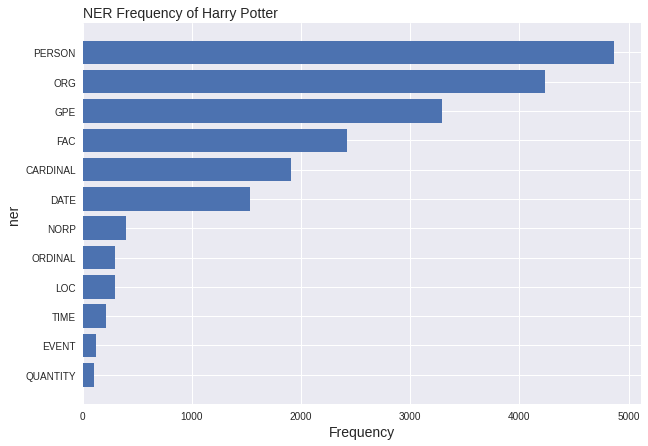

In [ ]:
ner = ner_count['ner']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(ner, count)
ax.invert_yaxis()
ax.set_title('NER Frequency of Harry Potter',loc ='left', size = 14)
ax.set_ylabel('ner', size = 14)
ax.set_xlabel('Frequency', size = 14)
fig.show()

In [ ]:
!wget -O taipei_sans_tc_beta.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download

# 新增字體
matplotlib.font_manager.fontManager.addfont('taipei_sans_tc_beta.ttf')

# 將 font-family 設為 Taipei Sans TC Beta
# 設定完後，之後的圖表都可以顯示中文了
matplotlib.rc('font', family='Taipei Sans TC Beta')


--2021-12-05 17:09:34--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 172.217.14.110, 2607:f8b0:4007:80e::200e
Connecting to drive.google.com (drive.google.com)|172.217.14.110|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ne8l2t70e4j2abtur0ecjjumkv7esvb2/1638724125000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_ [following]
--2021-12-05 17:09:38--  https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ne8l2t70e4j2abtur0ecjjumkv7esvb2/1638724125000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving doc-0k-9o-docs.googleusercontent.com (doc-0k-9o-docs.googleusercontent.com)... 142.250.72.225, 2607:f8b0:4007:816::2001
Connecting to doc-0k-9o-docs.googleusercontent.com (doc-0k-9o-docs.googleusercontent.com)|142.250.72.225|

    篩選、統計並顯示涉及到的人名(PERSON)資料

由下圖可得知，"朱立倫"人名在PTT核四公投討論裡出現的次數為最多，柯文哲為其次，蔡英文為第三。因朱立倫現身為國民黨主席，且在過往擔任新北市長期間多次表達對核四看法，前後態度令網友關注，因而討論度最高。

黃士修為「2021年核四商轉公投」公投案領銜人，近期在電視辯論上的激進發言引起民眾熱議，因而令鄉民對其做議論。而有部分鄉民稱呼他為"土條"，為對黃士修的諷稱，多為屬貶意之意。

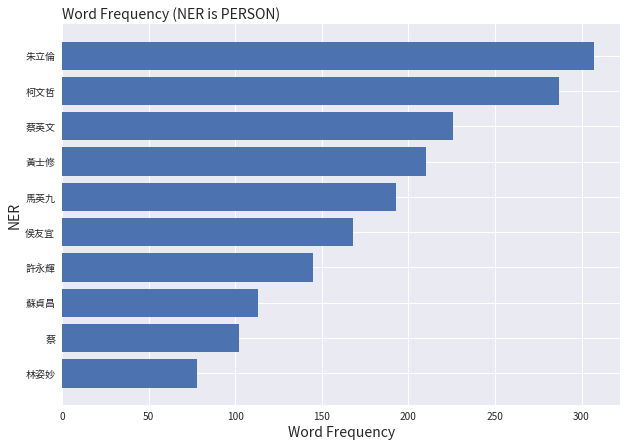

In [ ]:
# 篩選ner為名詞的資料
l_noun = ["PERSON"]
PERSON = entity_table[entity_table.ner.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前10個
ner_count = PERSON.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(10).reset_index()
ner_count

# 設定中文字形
 
word = ner_count['word']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is PERSON)',loc ='left', size = 14)
ax.set_ylabel('NER', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

In [ ]:
keyword_list = ['黃士修','土條']
select = sentence_table[sentence_table['sentence'].str.contains('|'.join(keyword_list),regex=True)]
print(f"{' '.join(keyword_list)}：{select.shape[0]}篇相關貼文")
select.drop_duplicates(subset='sentence')

黃士修 土條：380篇相關貼文


,artDate,sentence
1980,2021/10/27,黃士修整天在說核廢有多安全
1983,2021/10/27,不然黃士修去說服金門人也可以啊跟金門人說核廢有多安全
2069,2021/10/27,台灣人尤其是核工系的八成都長得像土條
5215,2021/11/01,正方代表黃士修
5935,2021/11/02,然後又要對上土條
...,...,...
23573,2021/11/29,在節目錄影中被土條嗆
23576,2021/11/29,請問一下土條這些言論
23580,2021/11/29,有土條的卦嗎
23605,2021/11/29,順便建議土條代表民眾黨選新北市長，


1.   經篩選ner為名詞(組織)的資料可得知，國民黨和民進黨因為在核四公投裡分別代表著正方與反方的角色，因此討論度為最高。
2.   而國民黨因多數人士對核四公投態度曖昧、態度前後不一，引發鄉民間的論戰，因而出現頻率皆高於其他團體。
3.   當中可看到"台積電"也為網友討論度高的組織，因為黃士修曾在辯論會上比喻台積電的晶圓廢液問題，表示「台積電的晶圓廢液都無法處理了，反而是已經被證實可系統化處理的核廢料卻被政府認定無法處理」。

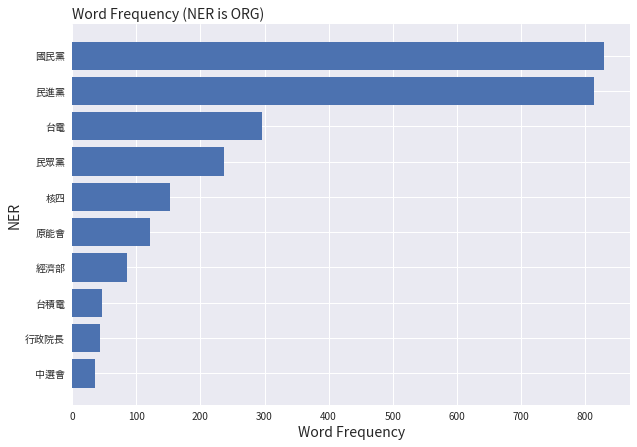

In [ ]:
# 篩選ner為名詞(團體)的資料
l_noun = ["ORG"]
ORG = entity_table[entity_table.ner.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前10個
ner_count = ORG.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(10).reset_index()
ner_count

# 設定中文字形
plt.rcParams['font.sans-serif'] = ['SimHei'] 
word = ner_count['word']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is ORG)',loc ='left', size = 14)
ax.set_ylabel('NER', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()


經篩選ner為名詞(國家)的資料可得知，"台灣"為最多人所提到的，但在相關的貼文中，有"台灣人"的言詞中，也有不少是與核能、公投無關的。

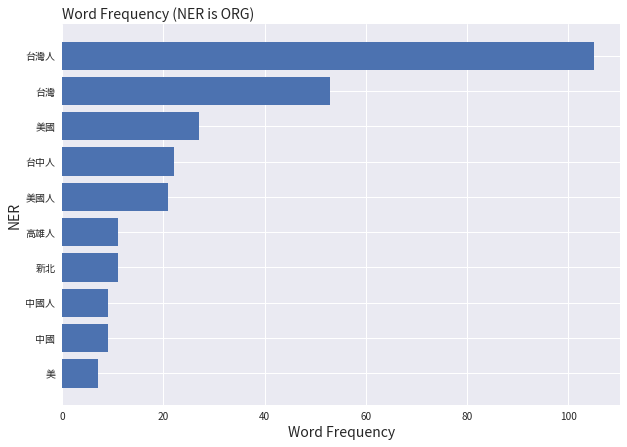

In [ ]:
# 篩選ner為名詞的資料
l_noun = ["NORP"]
NORP = entity_table[entity_table.ner.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前10個
ner_count = NORP.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(10).reset_index()
ner_count

# 設定中文字形
#plt.rcParams['font.sans-serif'] = ['SimHei'] 
word = ner_count['word']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is ORG)',loc ='left', size = 14)
ax.set_ylabel('NER', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

In [ ]:
keyword_list = ['台灣人']
select = sentence_table[sentence_table['sentence'].str.contains('|'.join(keyword_list),regex=True)]
print(f"{' '.join(keyword_list)}：{select.shape[0]}篇相關貼文")
select.head(5)

台灣人：132篇相關貼文


,artDate,sentence
89,2021/10/05,台灣人民要花錢花納稅錢養核廢料養萬年嗎
113,2021/10/08,明明是台灣人名字卻有五個字
200,2021/10/09,或許早有一批特務在對岸活動，應該也招募了不少台灣人當特務
881,2021/10/20,這份來自他親身強烈體會的身為台灣人的悲哀，必定在內心驅動他盡力地在暗地裡保
1233,2021/10/25,但更多台灣人看在眼裡心裡是幹意滿點的


## 探索分析 - POS

**POS 種類分析**

查看辨識出哪幾種POS

In [ ]:
pos_table['pos'].unique()

array(['Nc', 'VJ', 'Nb', 'Na', 'VH', 'Neu', 'Nf', 'VC', 'FW', 'Caa',
       'COMMACATEGORY', 'VA', 'VG', 'VE', 'D', 'P', 'VK', 'VL', 'Nep',
       'VB', 'VF', 'Cbb', 'SHI', 'VHC', 'Nh', 'Da', 'Ng', 'A', 'DE',
       'Neqa', 'Ncd', 'VCL', 'Nes', 'Di', 'Nd', 'VAC', 'Dfa', 'V_2', 'VD',
       'T', 'VI', 'Dk', 'Nv', 'COLONCATEGORY', 'Cab', 'I', 'DM',
       'PERIODCATEGORY', 'Cba', 'Dfb', 'Neqb', 'PARENTHESISCATEGORY',
       'SEMICOLONCATEGORY'], dtype=object)

看看除了標點符號，大部分的POS都是哪一類。與預測結果相似，名詞為最多，其次為副詞，第三為動作及物動詞。

In [ ]:
pos_filter = pos_table[~pos_table.pos.isin(['COMMACATEGORY', 'PARENTHESISCATEGORY', 'PERIODCATEGORY', 'COLONCATEGORY'])]

pos_count = pos_filter.groupby(['pos'])['pos'] \
                             .count() \
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False) \
                             .head(12)
pos_count

,pos,count
15,Na,40507
5,D,26733
36,VC,17727
17,Nc,12608
42,VH,11947
6,DE,8162
29,P,7776
16,Nb,7713
39,VE,7519
33,VA,7157


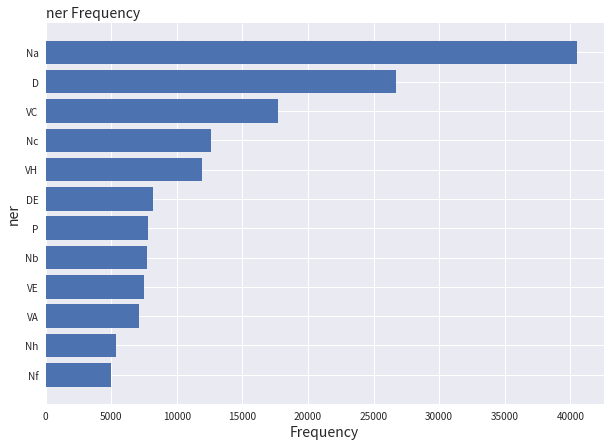

In [ ]:
pos = pos_count['pos']
count = pos_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(pos, count)
ax.invert_yaxis()
ax.set_title('ner Frequency',loc ='left', size = 14)
ax.set_ylabel('ner', size = 14)
ax.set_xlabel('Frequency', size = 14)
fig.show()

POS 詞性列表: 中研院列表: https://ckip.iis.sinica.edu.tw/service/corenlp/

Na: 普通名詞

D: 副詞

VC: 動作及物動詞

Nb: 專有名詞

FW: 外文

VH: 狀態不及物動詞

Nh: 代名詞

DE: 的之得地

P: 介詞

VA: 動作不及物動詞

T: 語助詞

SHI: 是

**涉及到的名詞(Na)**

我們可以找出談論核四公投時大部分討論到的專有名詞，探索大家的關注焦點。 名詞可以分為「Na: 普通名詞」、「Nb: 專有名詞」等。

In [ ]:
# 篩選pos為名詞的資料
l_noun = ["Nb"] #,"Na"
noun = pos_table[pos_table.pos.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前13個
# 寫法一
noun_count = noun.groupby('word')['word'].agg(['count'])
noun_count = noun_count.sort_values(['count'],ascending=False)['count'].nlargest(15).reset_index()
noun_count.head(10)

,word,count
0,國民黨,862
1,民進黨,832
2,朱立倫,307
3,柯文哲,288
4,民眾黨,252
5,蔡英文,226
6,黃士修,211
7,馬英九,196
8,侯友宜,169
9,許永輝,145


與上述PER所呈現的實體結果類似，國民黨、民進黨、朱立倫與民眾黨的柯文哲皆是與這次核四公投案為直接相關的組織/人物，因此自然會成為大家的討論與關注焦點。

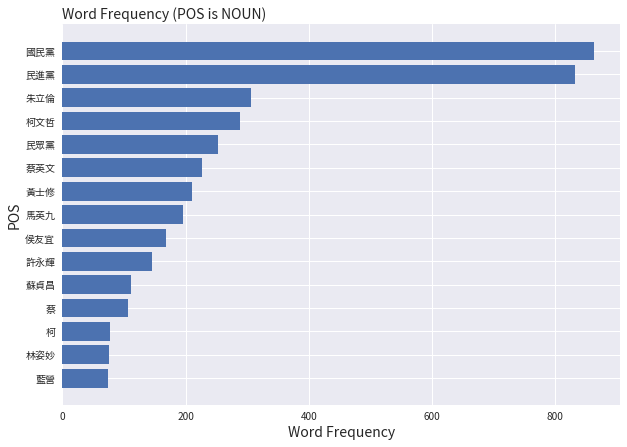

In [ ]:
# 設定中文字形
plt.rcParams['font.sans-serif'] = ['SimHei'] 
word = noun_count['word']
count = noun_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (POS is NOUN)',loc ='left', size = 14)
ax.set_ylabel('POS', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

## 利用SnowNLP進行情緒分析

1.   SnowNLP 針對中文設計，可以提取句子的情緒分類 
2.   使用文件分類法，套件已預先用文集訓練模型以判斷情緒 
3.   情緒值在 0~1之間，代表負面到正面 
4.   官方github: https://github.com/isnowfy/snownlp



In [ ]:
#pip install SnowNLP

In [ ]:
from snownlp import SnowNLP

將句子和日期合併，方便之後做分析

In [ ]:
sentence_table = pd.read_csv("/content/drive/MyDrive/ColabNotebooks/Colab_Notebooks_study/公投/sentence_table_核四.csv") #匯資料
MetaData_df = pd.read_csv("/content/drive/MyDrive/ColabNotebooks/Colab_Notebooks_study/公投/公投rawdata政黑/PTT_核四Politics_articleMetaData.csv") #匯資料
sentiment_date = pd.merge(sentence_table,MetaData_df[['artDate','artUrl']],on='artDate',how='left')
sentiment_date['sentence'] = sentiment_date.sentence.apply(lambda x: re.sub('(媒體來源|記者署名|完整新聞標題|完整新聞內文|完整新聞連結|(或短網址)|備註:|備註請放最後面|違者新聞文章刪除)', '', x))
sentiment_date['sentence'] = sentiment_date.sentence.apply(lambda x: re.sub('(http|https)://.*', '', x))
sentiment_date['sentence'] = sentiment_date.sentence.apply(lambda x: re.sub('[^\u4e00-\u9fa5]+', '',x))
sentiment_date['sentence'].replace('', np.nan, inplace=True)
sentiment_date.dropna(subset=['sentence'], inplace=True)
sentiment_date = sentiment_date.drop_duplicates(subset=['sentence'])
sentiment_date

,artDate,sentence,artUrl
0,2021/10/01,中國忌憚美英澳核潛艇合作王毅五重危害,https://www.ptt.cc/bbs/HatePolitics/M.16330501...
8,2021/10/01,中央社記者邱國強北京,https://www.ptt.cc/bbs/HatePolitics/M.16330501...
12,2021/10/01,美英澳合組聯盟及核潛艇技術合作引起中國強烈反彈,https://www.ptt.cc/bbs/HatePolitics/M.16330501...
16,2021/10/01,中國國務委員兼外長王毅,https://www.ptt.cc/bbs/HatePolitics/M.16330501...
20,2021/10/01,日聲稱,https://www.ptt.cc/bbs/HatePolitics/M.16330501...
...,...,...,...
1467388,2021/11/29,膩在其中,https://www.ptt.cc/bbs/HatePolitics/M.16381501...
1467459,2021/11/29,要不要好好查一查,https://www.ptt.cc/bbs/HatePolitics/M.16381501...
1467530,2021/11/29,公投還有二個多星期請工商企業代表們走出缺電的加護病房出來講幾句話吧,https://www.ptt.cc/bbs/HatePolitics/M.16381501...
1467672,2021/11/29,全世界都在減碳減甲烷台灣卻反其道而行捨核電就燃氣世界怎麼不跟上台灣了,https://www.ptt.cc/bbs/HatePolitics/M.16381501...


In [ ]:
def get_sentiment(sent):
    s = SnowNLP(sent)
    return s.sentiments

# 幫每句話加上情緒分數
sentiment_date['sentimentValue'] = sentiment_date.apply(lambda row : get_sentiment(row['sentence'],), axis = 1)
sentiment_date

,artDate,sentence,artUrl,sentimentValue
0,2021/10/01,中國忌憚美英澳核潛艇合作王毅五重危害,https://www.ptt.cc/bbs/HatePolitics/M.16330501...,0.987215
8,2021/10/01,中央社記者邱國強北京,https://www.ptt.cc/bbs/HatePolitics/M.16330501...,0.958706
12,2021/10/01,美英澳合組聯盟及核潛艇技術合作引起中國強烈反彈,https://www.ptt.cc/bbs/HatePolitics/M.16330501...,0.981349
16,2021/10/01,中國國務委員兼外長王毅,https://www.ptt.cc/bbs/HatePolitics/M.16330501...,0.972022
20,2021/10/01,日聲稱,https://www.ptt.cc/bbs/HatePolitics/M.16330501...,0.103727
...,...,...,...,...
1467388,2021/11/29,膩在其中,https://www.ptt.cc/bbs/HatePolitics/M.16381501...,0.500000
1467459,2021/11/29,要不要好好查一查,https://www.ptt.cc/bbs/HatePolitics/M.16381501...,0.024339
1467530,2021/11/29,公投還有二個多星期請工商企業代表們走出缺電的加護病房出來講幾句話吧,https://www.ptt.cc/bbs/HatePolitics/M.16381501...,0.172310
1467672,2021/11/29,全世界都在減碳減甲烷台灣卻反其道而行捨核電就燃氣世界怎麼不跟上台灣了,https://www.ptt.cc/bbs/HatePolitics/M.16381501...,0.094762


In [ ]:
sentiment_date = sentiment_date[sentiment_date['sentimentValue']>0]
sentiment_date['sentimentValue'].describe() # 20652句話

count    15479.000000
mean         0.565650
std          0.284169
min          0.100017
25%          0.309591
50%          0.552151
75%          0.835100
max          1.000000
Name: sentimentValue, dtype: float64

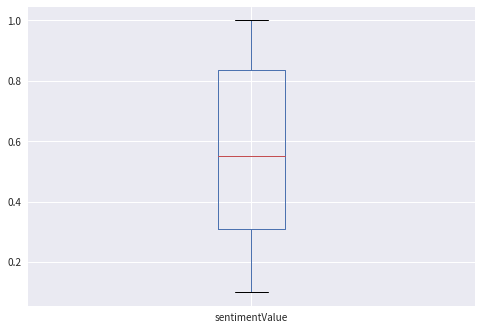

In [ ]:
# 情緒分布的盒狀圖
boxplot = sentiment_date.boxplot(column=['sentimentValue'], showfliers=False)
boxplot

將每天的情緒分數取平均，並轉換時間格式為天。

In [ ]:
sentiment_date['artDate'] =  pd.to_datetime(sentiment_date['artDate']).dt.date
sentiment_count = sentiment_date.groupby(['artDate'])['sentimentValue'].mean().reset_index()
sentiment_count

,artDate,sentimentValue
0,2021-10-01,0.689467
1,2021-10-05,0.589600
2,2021-10-06,0.798747
3,2021-10-07,0.593546
4,2021-10-08,0.397543
5,2021-10-09,0.697392
6,2021-10-10,0.657017
7,2021-10-11,0.580938
8,2021-10-12,0.595740
9,2021-10-13,0.539326


隨著核四公投案逐漸接近，加上辯論會的舉辦、媒體上訊息的揭露與社群媒體的宣傳，讓網民開始與2018年的以核養綠公投做連結，並更了解這次核四公投的背景與內容。我們推測因以上原因而讓情緒分數在11月開始時即趨向穩定。

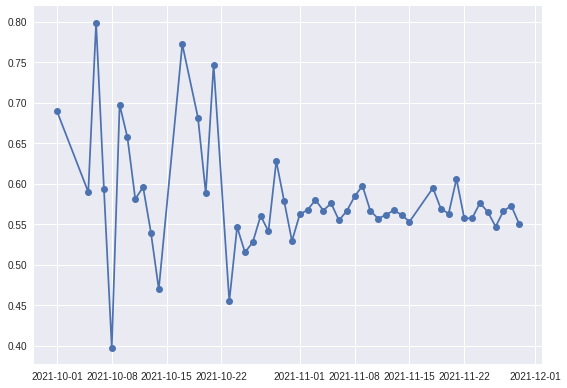

In [ ]:
# 平均情緒分數時間趨勢
plt.style.use('seaborn')

dates = sentiment_count['artDate']
y = sentiment_count['sentimentValue']

plt.plot_date(dates, y, linestyle='solid')
plt.gcf().autofmt_xdate
plt.tight_layout()

plt.show()

**正面詞彙探索** 

In [ ]:
# 篩時間區間
startdate = pd.to_datetime("2021-10-01").date()
enddate = pd.to_datetime("2021-11-30").date()
filter_sentiment = sentiment_date[sentiment_date.artDate.between(startdate, enddate)]
filter_sentiment = filter_sentiment.loc[filter_sentiment['sentimentValue'] >= 0.6]

# 看一下正面句子都在討論甚麼
filter_sentiment


,artDate,sentence,artUrl,sentimentValue
0,2021-10-01,中國忌憚美英澳核潛艇合作王毅五重危害,https://www.ptt.cc/bbs/HatePolitics/M.16330501...,0.987215
8,2021-10-01,中央社記者邱國強北京,https://www.ptt.cc/bbs/HatePolitics/M.16330501...,0.958706
12,2021-10-01,美英澳合組聯盟及核潛艇技術合作引起中國強烈反彈,https://www.ptt.cc/bbs/HatePolitics/M.16330501...,0.981349
16,2021-10-01,中國國務委員兼外長王毅,https://www.ptt.cc/bbs/HatePolitics/M.16330501...,0.972022
24,2021-10-01,美英澳核潛艇技術合作將為亞太帶來五重危害,https://www.ptt.cc/bbs/HatePolitics/M.16330501...,0.814500
...,...,...,...,...
1466394,2021-11-29,做不到這些高成本的發電模式請問每度電要漲多少,https://www.ptt.cc/bbs/HatePolitics/M.16381501...,0.659336
1466607,2021-11-29,這還不適用在一般民用電力將來勢必普及應用大家做好準備了,https://www.ptt.cc/bbs/HatePolitics/M.16381501...,0.617361
1466678,2021-11-29,聯合國第廿六屆氣候峰會剛落幕不久,https://www.ptt.cc/bbs/HatePolitics/M.16381501...,0.784256
1466749,2021-11-29,核能發電尤其核四發電裝置容量二七萬千瓦占夏日尖峰發電八左右,https://www.ptt.cc/bbs/HatePolitics/M.16381501...,0.999990


In [ ]:
# 把時間分數和之前斷詞的token table做 join
#pos_table = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/Colab_Notebooks_study/公投/pos_table_核四.csv')
positive_words = pd.merge(filter_sentiment,pos_table,on='artDate',left_index=True, right_index=True)
#positive_words = pd.concat([filter_sentiment,pos_table]) 
positive_words = positive_words[['artDate','word','sentimentValue']]
positive_words

,artDate,word,sentimentValue
0,2021-10-01,中國,0.987215
8,2021-10-01,重,0.958706
12,2021-10-01,記者,0.981349
16,2021-10-01,英澳,0.972022
24,2021-10-01,中國,0.814500
...,...,...,...
226478,2021-10-31,艾普羅,0.602663
226558,2021-10-31,男神,0.856840
226958,2021-10-31,上,0.619356
227838,2021-10-31,足夠,0.718104


In [ ]:
positive_words = positive_words[positive_words.apply(lambda x: len(x['word'])>1, axis=1)]
positive_words

,artDate,word,sentimentValue
0,2021-10-01,中國,0.987215
12,2021-10-01,記者,0.981349
16,2021-10-01,英澳,0.972022
24,2021-10-01,中國,0.814500
28,2021-10-01,國務,0.851848
...,...,...,...
225918,2021-10-31,總統,0.741845
225998,2021-10-31,反感,0.989920
226478,2021-10-31,艾普羅,0.602663
226558,2021-10-31,男神,0.856840


**正面詞彙文字雲**

In [ ]:
# 自定停用字
with open('/content/drive/MyDrive/ColabNotebooks/Colab_Notebooks_study/公投/文件分析dict/stop_words.txt') as f:
    stop_words = f.read().splitlines()

print(stop_words)

[',', '?', '、', '。', '“', '”', '《', '》', '！', '，', '：', '；', '？', '再', '本來', '是不是', '一個', '這種', '人民', '末##末', '啊', '阿', '哎', '哎呀', '哎喲', '唉', '我', '我們', '按', '按照', '依照', '吧', '吧噠', '把', '罷了', '被', '本', '本著', '比', '比方', '比如', '鄙人', '彼', '彼此', '邊', '別', '別的', '別說', '並', '並且', '不比', '不成', '不單', '不但', '不獨', '不管', '不光', '不過', '不僅', '不拘', '不論', '不怕', '不然', '不如', '不特', '不惟', '不問', '不只', '朝', '朝著', '趁', '趁著', '乘', '沖', '除', '除此之外', '除非', '除了', '此', '此間', '此外', '從', '從而', '打', '待', '但', '但是', '當', '當著', '到', '得', '的', '的話', '等', '等等', '地', '第', '叮咚', '對', '對於', '多', '多少', '而', '而況', '而且', '而是', '而外', '而言', '而已', '爾後', '反過來', '反過來說', '反之', '非但', '非徒', '否則', '嘎', '嘎登', '該', '趕', '個', '各', '各個', '各位', '各種', '各自', '給', '根據', '跟', '故', '故此', '固然', '關於', '管', '歸', '果然', '果真', '過', '哈', '哈哈', '呵', '和', '何', '何處', '何況', '何時', '嘿', '哼', '哼唷', '呼哧', '乎', '嘩', '還是', '還有', '換句話說', '換言之', '或', '或是', '或者', '極了', '及', '及其', '及至', '即', '即便', '即或', '即令', '即若', '即使', '幾', '幾時', '己', '既', '既然', '既是', '繼而', '加之', 

In [ ]:
!wget -O taipei_sans_tc_beta.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download

# 新增字體
matplotlib.font_manager.fontManager.addfont('taipei_sans_tc_beta.ttf')

# 將 font-family 設為 Taipei Sans TC Beta
# 設定完後，之後的圖表都可以顯示中文了
matplotlib.rc('font', family='Taipei Sans TC Beta')


--2021-12-05 17:55:58--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 172.217.14.110, 2607:f8b0:4007:80e::200e
Connecting to drive.google.com (drive.google.com)|172.217.14.110|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/u7igj7lvh40qu65h6k5nn2gkcrcmm07v/1638726900000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_ [following]
--2021-12-05 17:55:59--  https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/u7igj7lvh40qu65h6k5nn2gkcrcmm07v/1638726900000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving doc-0k-9o-docs.googleusercontent.com (doc-0k-9o-docs.googleusercontent.com)... 142.250.72.225, 2607:f8b0:4007:816::2001
Connecting to doc-0k-9o-docs.googleusercontent.com (doc-0k-9o-docs.googleusercontent.com)|142.250.72.225|

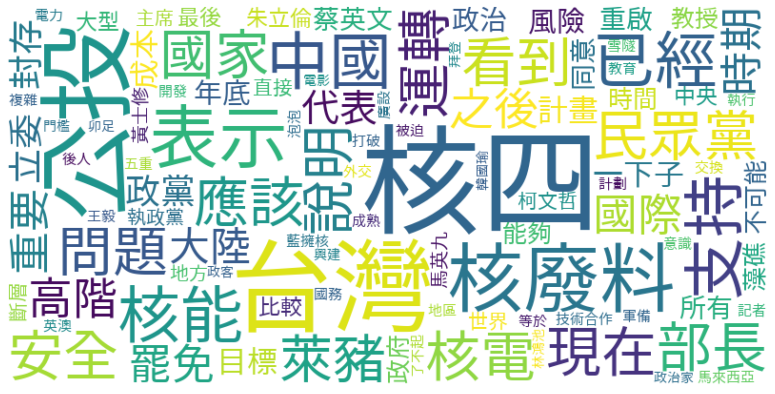

In [ ]:
# 匯入自訂的 stop words (預設只有英文的)
stop_words_pos = stop_words
stop_words_pos.extend(('重啟核四','國民黨','民進黨'))
stop_words_pos = set(stop_words_pos)

# 設定中文字形
font_path = 'taipei_sans_tc_beta.ttf'

# 可以設定字型大小和背景顏色
wordcloud = WordCloud(stopwords=stop_words_pos,font_path=font_path,width=800, height = 400, max_words=100, background_color="white")

wordcloud.generate(' '.join(positive_words['word']))
# Display the generated image:
plt.figure(figsize = (14,7))
plt.imshow(wordcloud, interpolation="bilinear")

plt.axis("off")
plt.show()

在正面情緒的句子中，「核四」與「公投」討論度高，也因為其蓋在臺灣，是屬於臺灣在地議題，加上與核能有關的問題如國家、核能、核廢料等同樣也是網友討論的理性、正面詞彙。

**負面詞彙文字雲**

從上圖中可以發現 10/27,11/30 的情緒特別低，我們把那天的負面句子挑出來看看他們都用甚麼詞，根據上面的盒狀圖，我們選取情緒值小於0.5的句子。

In [ ]:
# 篩時間區間
# sentiment_date.loc[sentiment_date.to_datetime(['2021-09-17', '2010-01-04'])]

date1 = pd.to_datetime('2021-10-27').date()
date2 = pd.to_datetime('2021-11-30').date()
filter_sentiment = sentiment_date[sentiment_date.artDate.isin([date1,date2])]
filter_sentiment = filter_sentiment.loc[filter_sentiment['sentimentValue'] < 0.5]

# 看一下負面句子都在討論甚麼
filter_sentiment

,artDate,sentence,artUrl,sentimentValue
40912,2021-10-27,受限核電廠的大小跟圍阻體,https://www.ptt.cc/bbs/HatePolitics/M.16352958...,0.366652
40987,2021-10-27,發電機也不能擴充跟增加,https://www.ptt.cc/bbs/HatePolitics/M.16352958...,0.421689
41062,2021-10-27,而且高階核廢料還會佔場地空間,https://www.ptt.cc/bbs/HatePolitics/M.16352958...,0.288695
41137,2021-10-27,塞滿了核電廠就退役,https://www.ptt.cc/bbs/HatePolitics/M.16352958...,0.450236
41737,2021-10-27,核能是不是被科韓白粉吹出來的產物呢,https://www.ptt.cc/bbs/HatePolitics/M.16352958...,0.249049
...,...,...,...,...
93562,2021-10-27,根本一半都不到,https://www.ptt.cc/bbs/HatePolitics/M.16352958...,0.313610
93637,2021-10-27,已經快了欸,https://www.ptt.cc/bbs/HatePolitics/M.16352958...,0.203138
93712,2021-10-27,然後台積電要擴廠,https://www.ptt.cc/bbs/HatePolitics/M.16352958...,0.409642
93862,2021-10-27,我覺得公投三接要繼續蓋,https://www.ptt.cc/bbs/HatePolitics/M.16352958...,0.161327


In [ ]:
# 把時間分數和之前斷詞的token table做 join
negative_words = pd.merge(filter_sentiment,pos_table,on='artDate',left_index=True, right_index=True)
negative_words = negative_words[['artDate','sentimentValue','word']]
negative_words

,artDate,sentimentValue,word
40912,2021-10-27,0.366652,怎樣
40987,2021-10-27,0.421689,談
41062,2021-10-27,0.288695,有
41137,2021-10-27,0.450236,與
41737,2021-10-27,0.249049,夏天
...,...,...,...
93562,2021-10-27,0.313610,共同
93637,2021-10-27,0.203138,還是
93712,2021-10-27,0.409642,自己
93862,2021-10-27,0.161327,///


In [ ]:
# 篩選只有單個字元的結果
negative_words = negative_words[negative_words.apply(lambda x: len(x['word'])>1, axis=1)]

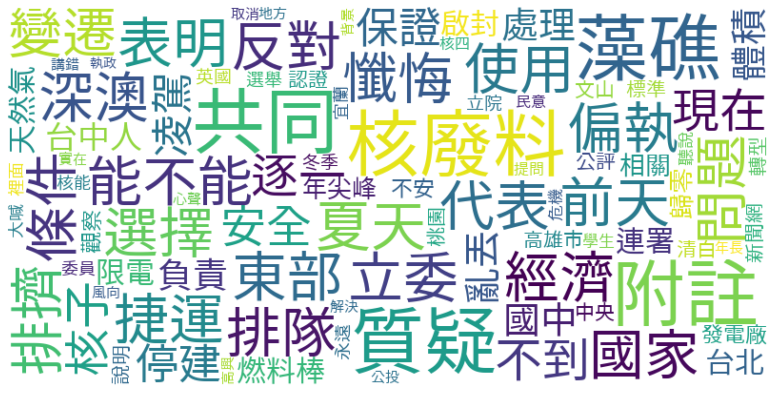

In [ ]:
# 匯入自訂的 stop words (預設只有英文的)
stop_words_neg = stop_words
stop_words_neg.extend(('重啟核四','國民黨','民進黨'))
stop_words_neg = set(stop_words_neg)


# 設定中文字形
font_path = 'taipei_sans_tc_beta.ttf'

# 可以設定字型大小和背景顏色
wordcloud = WordCloud(
                stopwords=stop_words_neg,font_path=font_path,width=800, height = 400, max_words=100, background_color="white")\
                .generate(' '.join(negative_words['word']))

# Display the generated image:
plt.figure(figsize = (14,7))
plt.imshow(wordcloud, interpolation="bilinear")

plt.axis("off")
plt.show()

負面情緒多為批評、質疑核廢料，等安全的措施，也提到氣候變遷的議題，還有同在附近的深澳電廠正與反另外同為公投案的藻礁議題也常被網友拿來一起討論、做比較。

In [ ]:
%pip install nltk==3.4

## 文辭和文件分析
- #### TF_IDF
- #### Bigram
- #### Ngram預測模型
- #### Bigram視覺化
- #### Pairwise Correlation - 詞彙相關性
- #### 文章相似度

列出在本次實作過程中我們所使用到的相關套件，在這個Jupyter Notebook當中我們將會簡單的展示這些套件的使用方式，關於各個套件的進階使用請同學參照其官網的說明。

pandas: 一個資料分析的函式庫，提供了DataFrame等資料格式，與資料處理的函數。

numpy: 為科學運算所提供的套件。提供許多數學公式的實作以及高效率的陣列、矩陣運算。

NLTK: 全名為Natural Language Tool Kit，自然語言處理工具。

jieba: 中文斷詞套件。

re: 正規表達式套件。

math: 數學運算工具。

collections: 提供額外的數據類型。

wordcloud: 文字雲繪圖工具。

matplotlib: 繪圖工具。

networkx: 網絡圖建構、繪製工具。

CountVectorizer,TfidfTransformer: sklearn中計算詞頻與tf-idf的套件。

numpy.linalg: 矩陣與向量運算套件。

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib
import re
import jieba
import jieba.analyse
from datetime import datetime
from wordcloud import WordCloud 
import math
from nltk import ngrams
from collections import defaultdict
from nltk import FreqDist
from collections import Counter, namedtuple
import networkx as nx
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from numpy.linalg import norm

In [ ]:
plt.rcParams['font.sans-serif']=['SimHei'] #使圖中中文能正常顯示
plt.rcParams['axes.unicode_minus']=False #使負號能夠顯示

In [ ]:
#cloab 字體設定
!wget -O taipei_sans_tc_beta.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download

# 新增字體
matplotlib.font_manager.fontManager.addfont('taipei_sans_tc_beta.ttf')

# 將 font-family 設為 Taipei Sans TC Beta
# 設定完後，之後的圖表都可以顯示中文了
matplotlib.rc('font', family='Taipei Sans TC Beta')

--2021-12-05 15:01:29--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 172.217.14.110, 2607:f8b0:4007:80e::200e
Connecting to drive.google.com (drive.google.com)|172.217.14.110|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/hm3e6dlk1dg0uibl7gjpeeso5d299jnl/1638716475000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_ [following]
--2021-12-05 15:01:33--  https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/hm3e6dlk1dg0uibl7gjpeeso5d299jnl/1638716475000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving doc-0k-9o-docs.googleusercontent.com (doc-0k-9o-docs.googleusercontent.com)... 142.250.72.225, 2607:f8b0:4007:816::2001
Connecting to doc-0k-9o-docs.googleusercontent.com (doc-0k-9o-docs.googleusercontent.com)|142.250.72.225|

In [ ]:
keywords = ['核四','核能','核廢料','重啟核四','無核家園','以核養綠','綠色和平','非核家園']
toMatch = '|'.join(keywords)
MetaData = MetaData.loc[MetaData['sentence'].str.contains(toMatch) | MetaData['artTitle'].str.contains(toMatch), :]
MetaData.reset_index(inplace=True, drop=True) #重設index
MetaData

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence
0,[新聞]中國忌憚美英澳核潛艇合作王毅：五重危,2021/10/01,01:02:45,https://www.ptt.cc/bbs/HatePolitics/M.16330501...,starport,HatePolitics,11,5,1,中國忌憚美英澳核潛艇合作 王毅：五重危害\nhttps://bit.ly/3A9dm2d\n...
1,[黑特]誰能告訴我反對核四的理由到底是什麼,2021/10/05,07:55:34,https://www.ptt.cc/bbs/HatePolitics/M.16334205...,nobody0303,HatePolitics,26,2,3,這個世界這麼多地震天災人禍\n去探討極小機率會發生的重大災難\n根本一點意義都沒有\n問題是...
2,Re:[黑特]誰能告訴我反對核四的理由到底是什麼,2021/10/05,09:10:27,https://www.ptt.cc/bbs/HatePolitics/M.16334250...,loser1,HatePolitics,34,9,6,因為一開始就是為了核四而核四，\n四十年前蔣經國就把他給暫停了，\n然後好伯村又拿出來當政見...
3,Re:[黑特]誰能告訴我反對核四的理由到底是什麼,2021/10/05,09:56:45,https://www.ptt.cc/bbs/HatePolitics/M.16334278...,twnndnpdnc,HatePolitics,2,0,0,其實不用說這麼複雜\n\n若是你偏綠反核\n想要堵偏藍擁核的嘴\n你就說\n華人社會最繁華的...
4,Re:[黑特]誰能告訴我反對核四的理由到底是什麼,2021/10/05,10:38:42,https://www.ptt.cc/bbs/HatePolitics/M.16334303...,chen740530,HatePolitics,14,5,0,核能電廠有保存期限 核電廠的空間等於壽命\n\n因為要擺放高階核廢料\n\n核一二三廠會達使...
...,...,...,...,...,...,...,...,...,...,...
1092,Re:[討論]這次公投怎麼投應該很簡單吧？,2021/11/29,10:11:45,https://www.ptt.cc/bbs/HatePolitics/M.16381807...,ff704,HatePolitics,14,2,3,台灣豬都不吃，台灣人當然不吃\n支持三接，藻礁根本醜，無感\n當然綁，嫌政府錢太多喔\n台灣...
1093,Re:[討論]民眾黨應該延攬有戰力的黃士修選台北市,2021/11/29,11:10:59,https://www.ptt.cc/bbs/HatePolitics/M.16381842...,neverfly,HatePolitics,1,0,1,"其實真的很適合啊，\n想像一下對話就知道：\n\n""那些就是貪婪的老人，貪1500的敬老金，..."
1094,[新聞]美國前能源部長呼籲延役加州惡魔谷核電廠,2021/11/29,13:35:19,https://www.ptt.cc/bbs/HatePolitics/M.16381929...,NARUTO,HatePolitics,38,10,5,1.新聞網址︰\nhttps://www.chinatimes.com/realtimene...
1095,Re:[討論]朱宅神是不是急了阿?,2021/11/29,15:27:53,https://www.ptt.cc/bbs/HatePolitics/M.16381996...,myIDis7,HatePolitics,10,4,1,職?\n根\n…這咖的話你也在分析？\n\n成衣商就只是蹭熱度專家\n\n風往哪邊吹就往哪邊...


In [ ]:
MetaData.head(3)


,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence
0,[新聞]中國忌憚美英澳核潛艇合作王毅：五重危,2021/10/01,01:02:45,https://www.ptt.cc/bbs/HatePolitics/M.16330501...,starport,HatePolitics,11,5,1,中國忌憚美英澳核潛艇合作 王毅：五重危害\nhttps://bit.ly/3A9dm2d\n...
1,[黑特]誰能告訴我反對核四的理由到底是什麼,2021/10/05,07:55:34,https://www.ptt.cc/bbs/HatePolitics/M.16334205...,nobody0303,HatePolitics,26,2,3,這個世界這麼多地震天災人禍\n去探討極小機率會發生的重大災難\n根本一點意義都沒有\n問題是...
2,Re:[黑特]誰能告訴我反對核四的理由到底是什麼,2021/10/05,09:10:27,https://www.ptt.cc/bbs/HatePolitics/M.16334250...,loser1,HatePolitics,34,9,6,因為一開始就是為了核四而核四，\n四十年前蔣經國就把他給暫停了，\n然後好伯村又拿出來當政見...


In [ ]:
MetaData.sentence.isna().values.any() #資料中有na值

False

In [ ]:
MetaData[MetaData.sentence.isna()] #有na值得資料

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence


In [ ]:
MetaData = MetaData[~MetaData.sentence.isna()] # 去除na值
MetaData

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence
0,[新聞]中國忌憚美英澳核潛艇合作王毅：五重危,2021/10/01,01:02:45,https://www.ptt.cc/bbs/HatePolitics/M.16330501...,starport,HatePolitics,11,5,1,中國忌憚美英澳核潛艇合作 王毅：五重危害\nhttps://bit.ly/3A9dm2d\n...
1,[黑特]誰能告訴我反對核四的理由到底是什麼,2021/10/05,07:55:34,https://www.ptt.cc/bbs/HatePolitics/M.16334205...,nobody0303,HatePolitics,26,2,3,這個世界這麼多地震天災人禍\n去探討極小機率會發生的重大災難\n根本一點意義都沒有\n問題是...
2,Re:[黑特]誰能告訴我反對核四的理由到底是什麼,2021/10/05,09:10:27,https://www.ptt.cc/bbs/HatePolitics/M.16334250...,loser1,HatePolitics,34,9,6,因為一開始就是為了核四而核四，\n四十年前蔣經國就把他給暫停了，\n然後好伯村又拿出來當政見...
3,Re:[黑特]誰能告訴我反對核四的理由到底是什麼,2021/10/05,09:56:45,https://www.ptt.cc/bbs/HatePolitics/M.16334278...,twnndnpdnc,HatePolitics,2,0,0,其實不用說這麼複雜\n\n若是你偏綠反核\n想要堵偏藍擁核的嘴\n你就說\n華人社會最繁華的...
4,Re:[黑特]誰能告訴我反對核四的理由到底是什麼,2021/10/05,10:38:42,https://www.ptt.cc/bbs/HatePolitics/M.16334303...,chen740530,HatePolitics,14,5,0,核能電廠有保存期限 核電廠的空間等於壽命\n\n因為要擺放高階核廢料\n\n核一二三廠會達使...
...,...,...,...,...,...,...,...,...,...,...
1092,Re:[討論]這次公投怎麼投應該很簡單吧？,2021/11/29,10:11:45,https://www.ptt.cc/bbs/HatePolitics/M.16381807...,ff704,HatePolitics,14,2,3,台灣豬都不吃，台灣人當然不吃\n支持三接，藻礁根本醜，無感\n當然綁，嫌政府錢太多喔\n台灣...
1093,Re:[討論]民眾黨應該延攬有戰力的黃士修選台北市,2021/11/29,11:10:59,https://www.ptt.cc/bbs/HatePolitics/M.16381842...,neverfly,HatePolitics,1,0,1,"其實真的很適合啊，\n想像一下對話就知道：\n\n""那些就是貪婪的老人，貪1500的敬老金，..."
1094,[新聞]美國前能源部長呼籲延役加州惡魔谷核電廠,2021/11/29,13:35:19,https://www.ptt.cc/bbs/HatePolitics/M.16381929...,NARUTO,HatePolitics,38,10,5,1.新聞網址︰\nhttps://www.chinatimes.com/realtimene...
1095,Re:[討論]朱宅神是不是急了阿?,2021/11/29,15:27:53,https://www.ptt.cc/bbs/HatePolitics/M.16381996...,myIDis7,HatePolitics,10,4,1,職?\n根\n…這咖的話你也在分析？\n\n成衣商就只是蹭熱度專家\n\n風往哪邊吹就往哪邊...


**資料清理**

去除特殊字元與標點符號

In [ ]:
#移除PTT貼新聞時會出現的格式用字
MetaData['sentence'] = MetaData.sentence.apply(lambda x: re.sub('(媒體來源|記者署名|完整新聞標題|完整新聞內文|完整新聞連結|(或短網址)|備註:|備註請放最後面|違者新聞文章刪除)', '', x))
MetaData['sentence'] = MetaData.sentence.apply(lambda x: re.sub('(http|https)://.*', '', x))
#只留下中文字
MetaData['sentence'] = MetaData.sentence.apply(lambda x: re.sub('[^\u4e00-\u9fa5]+', '',x))

In [ ]:
#設定繁體中文詞庫
jieba.set_dictionary('/content/drive/MyDrive/ColabNotebooks/Colab_Notebooks_study/公投/文件分析dict/dict.txt.big')

#新增stop words
#jieba.analyse.set_stop_words('/content/drive/MyDrive/week8/dict/stopwords.txt') #jieba.analyse.extract_tags才會作用
with open('/content/drive/MyDrive/ColabNotebooks/Colab_Notebooks_study/公投/文件分析dict/stop_words.txt',encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

In [ ]:
# 設定斷詞 function
def getToken(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1] # 篩選不在停用字的字與字元數大於1的字詞
    return seg_list

In [ ]:
data = MetaData.copy()
data['word'] = data.sentence.apply(getToken)

Building prefix dict from /content/drive/MyDrive/ColabNotebooks/Colab_Notebooks_study/公投/文件分析dict/dict.txt.big ...
Loading model from cache /tmp/jieba.ue9434503f10428595a87bc2aaf490016.cache
Loading model cost 1.596 seconds.
Prefix dict has been built successfully.


In [ ]:
# 將word欄位展開
data = data.explode('word')

In [ ]:
data.head(3)


,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence,word
0,[新聞]中國忌憚美英澳核潛艇合作王毅：五重危,2021/10/01,01:02:45,https://www.ptt.cc/bbs/HatePolitics/M.16330501...,starport,HatePolitics,11,5,1,中國忌憚美英澳核潛艇合作王毅五重危害中央社記者邱國強北京美英澳合組聯盟及核潛艇技術合作引起中...,中國
0,[新聞]中國忌憚美英澳核潛艇合作王毅：五重危,2021/10/01,01:02:45,https://www.ptt.cc/bbs/HatePolitics/M.16330501...,starport,HatePolitics,11,5,1,中國忌憚美英澳核潛艇合作王毅五重危害中央社記者邱國強北京美英澳合組聯盟及核潛艇技術合作引起中...,忌憚
0,[新聞]中國忌憚美英澳核潛艇合作王毅：五重危,2021/10/01,01:02:45,https://www.ptt.cc/bbs/HatePolitics/M.16330501...,starport,HatePolitics,11,5,1,中國忌憚美英澳核潛艇合作王毅五重危害中央社記者邱國強北京美英澳合組聯盟及核潛艇技術合作引起中...,美英


In [ ]:
#計算各詞彙在各文章中出現的次數
word_count = data.groupby(['artUrl','word'],as_index=False).size()
word_count.rename(columns={'size': 'count'}, inplace=True)

In [ ]:
word_count


,artUrl,word,count
0,https://www.ptt.cc/bbs/HatePolitics/M.16330501...,一紙空文,1
1,https://www.ptt.cc/bbs/HatePolitics/M.16330501...,一脈相承,1
2,https://www.ptt.cc/bbs/HatePolitics/M.16330501...,三方,1
3,https://www.ptt.cc/bbs/HatePolitics/M.16330501...,中國,5
4,https://www.ptt.cc/bbs/HatePolitics/M.16330501...,中國外交部,1
...,...,...,...
79258,https://www.ptt.cc/bbs/HatePolitics/M.16382001...,電要,1
79259,https://www.ptt.cc/bbs/HatePolitics/M.16382001...,非核,1
79260,https://www.ptt.cc/bbs/HatePolitics/M.16382001...,餘年,1
79261,https://www.ptt.cc/bbs/HatePolitics/M.16382001...,驟然,1


### TF-IDF

TF-IDF 是一種統計方法，可用來評估單詞對於文件的集合的重要程度

**計算每篇文章的詞數**

In [ ]:
total_words = data.groupby(['artUrl'],as_index=False).size()
total_words.rename(columns={'size': 'total'}, inplace=True)
total_words

,artUrl,total
0,https://www.ptt.cc/bbs/HatePolitics/M.16330501...,248
1,https://www.ptt.cc/bbs/HatePolitics/M.16334205...,41
2,https://www.ptt.cc/bbs/HatePolitics/M.16334250...,55
3,https://www.ptt.cc/bbs/HatePolitics/M.16334278...,63
4,https://www.ptt.cc/bbs/HatePolitics/M.16334303...,48
...,...,...
1092,https://www.ptt.cc/bbs/HatePolitics/M.16381807...,18
1093,https://www.ptt.cc/bbs/HatePolitics/M.16381842...,40
1094,https://www.ptt.cc/bbs/HatePolitics/M.16381929...,421
1095,https://www.ptt.cc/bbs/HatePolitics/M.16381996...,84


**合併需要的資料欄位** 

合併 每個詞彙在每個文章中出現的次數 與 每篇文章的詞數 

新增各個詞彙在所有詞彙中的總數欄位

In [ ]:
Referendum_words = word_count.merge(total_words,on = 'artUrl',how = 'left')
Referendum_words

,artUrl,word,count,total
0,https://www.ptt.cc/bbs/HatePolitics/M.16330501...,一紙空文,1,248
1,https://www.ptt.cc/bbs/HatePolitics/M.16330501...,一脈相承,1,248
2,https://www.ptt.cc/bbs/HatePolitics/M.16330501...,三方,1,248
3,https://www.ptt.cc/bbs/HatePolitics/M.16330501...,中國,5,248
4,https://www.ptt.cc/bbs/HatePolitics/M.16330501...,中國外交部,1,248
...,...,...,...,...
79258,https://www.ptt.cc/bbs/HatePolitics/M.16382001...,電要,1,221
79259,https://www.ptt.cc/bbs/HatePolitics/M.16382001...,非核,1,221
79260,https://www.ptt.cc/bbs/HatePolitics/M.16382001...,餘年,1,221
79261,https://www.ptt.cc/bbs/HatePolitics/M.16382001...,驟然,1,221


**計算 tf-idf 值**

以每篇文章爲單位，計算每個詞彙的 tf-idf 值

    TF (Term Frequency):某一個詞彙在某一個文件中所出現的頻率。
    詞彙在該文件中出現次數 / 該文件中詞彙總數
    IDF (Inverse Document Frequent):為文件數除以某特定詞彙有被多少文件所提及的數量取log。評估詞彙在文集的獨特性
    log( 總文件數量 / 包含該詞彙的文件數量 )

In [ ]:
#計算tf
Referendum_words_tf_idf = Referendum_words.assign(tf = Referendum_words.iloc[:,2]/Referendum_words.iloc[:,3])

In [ ]:
# 計算每個詞彙出現在幾篇文章中
idf_df = Referendum_words.groupby(['word'],as_index=False).size()
Referendum_words_tf_idf = Referendum_words_tf_idf.merge(idf_df,on = 'word',how = 'left')

In [ ]:
#計算idf
Referendum_words_tf_idf = Referendum_words_tf_idf.assign(idf = Referendum_words_tf_idf.iloc[:,5]
                                               .apply(lambda x: math.log((len(total_words)/x),10)))

Referendum_words_tf_idf = Referendum_words_tf_idf.drop(labels=['size'],axis=1)

In [ ]:
#計算tf*idf
Referendum_words_tf_idf = Referendum_words_tf_idf.assign(tf_idf = Referendum_words_tf_idf.iloc[:,4]*Referendum_words_tf_idf.iloc[:,5])

In [ ]:
Referendum_words_tf_idf.head()


,artUrl,word,count,total,tf,idf,tf_idf
0,https://www.ptt.cc/bbs/HatePolitics/M.16330501...,一紙空文,1,248,0.004032,3.040207,0.012259
1,https://www.ptt.cc/bbs/HatePolitics/M.16330501...,一脈相承,1,248,0.004032,3.040207,0.012259
2,https://www.ptt.cc/bbs/HatePolitics/M.16330501...,三方,1,248,0.004032,3.040207,0.012259
3,https://www.ptt.cc/bbs/HatePolitics/M.16330501...,中國,5,248,0.020161,1.240866,0.025017
4,https://www.ptt.cc/bbs/HatePolitics/M.16330501...,中國外交部,1,248,0.004032,3.040207,0.012259


**檢視結果**

In [ ]:
# 選出每篇文章，tf-idf值最大的五個詞
group = Referendum_words_tf_idf.groupby("artUrl").apply(lambda x : x.nlargest(5, "tf_idf"))

In [ ]:
group.loc[:,["word","tf_idf"]][0:15]


word    tf_idf
artUrl                                                                
https://www.ptt.cc/bbs/HatePolitics/M.163305016... 99    核潛艇  0.110330
                                                   116    王毅  0.073553
                                                   51     地區  0.051082
                                                   38     合作  0.041075
                                                   109    澳洲  0.037762
https://www.ptt.cc/bbs/HatePolitics/M.163342053... 192    減少  0.082819
                                                   175    划算  0.074151
                                                   176  利大於弊  0.074151
                                                   185    會少  0.074151
                                                   188    極小  0.074151
https://www.ptt.cc/bbs/HatePolitics/M.163342502... 223   四十年  0.085136
                                                   251    萬年  0.077713
                                                   214    來自  0.062472
                                                   230    找到  0.061738
                                                   210    中聾  0.055276

**計算整個文集中較常 tf-idf 值高的字**

由下表統計可得知，評估單詞對於文件的集合或詞庫中一份文件的重要程度的td-idf值前幾高的有同意、柯文、核廢料等...當中"同意"為公投選擇選項、"柯文"為網友對臺北市長的討論、"核廢料之儲存"為大家最擔心的核能議題之一。

In [ ]:
# 從每篇文章挑選出tf-idf最大的十個詞
(Referendum_words_tf_idf.groupby("artUrl").apply(lambda x : x.nlargest(10, "tf_idf")).reset_index(drop=True)
# 計算每個詞被選中的次數
.groupby(['word'],as_index=False).size()
).sort_values('size', ascending=False).head(10) #排序看前十名

,word,size
1780,同意,35
4294,柯文,34
4421,核廢料,32
7463,黃士,30
2150,國民黨,27
7390,馬英九,25
6136,處理,23
4214,朱立倫,22
2175,土條,21
4663,民進黨,18


### Bigram

In [ ]:
# 設定 bigram 斷詞 function
def bigram_getToken(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1]
    seg_list = ngrams(seg_list, 2)
    seg_list = [" ".join(w) for w in list(seg_list)]
    return seg_list

In [ ]:
Referendum_bigram = MetaData.copy()
Referendum_bigram["word"] = Referendum_bigram.sentence.apply(bigram_getToken)

In [ ]:
Referendum_bigram = Referendum_bigram.explode('word')
Referendum_bigram.head(3)

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence,word
0,[新聞]中國忌憚美英澳核潛艇合作王毅：五重危,2021/10/01,01:02:45,https://www.ptt.cc/bbs/HatePolitics/M.16330501...,starport,HatePolitics,11,5,1,中國忌憚美英澳核潛艇合作王毅五重危害中央社記者邱國強北京美英澳合組聯盟及核潛艇技術合作引起中...,中國 忌憚
0,[新聞]中國忌憚美英澳核潛艇合作王毅：五重危,2021/10/01,01:02:45,https://www.ptt.cc/bbs/HatePolitics/M.16330501...,starport,HatePolitics,11,5,1,中國忌憚美英澳核潛艇合作王毅五重危害中央社記者邱國強北京美英澳合組聯盟及核潛艇技術合作引起中...,忌憚 美英
0,[新聞]中國忌憚美英澳核潛艇合作王毅：五重危,2021/10/01,01:02:45,https://www.ptt.cc/bbs/HatePolitics/M.16330501...,starport,HatePolitics,11,5,1,中國忌憚美英澳核潛艇合作王毅五重危害中央社記者邱國強北京美英澳合組聯盟及核潛艇技術合作引起中...,美英 核潛艇


**統計最常出現的bigram組合**

由以下統計可得知，公投+大選為最常出現之組合，因為這次四大公投其中之一為公投綁大選因而引起網友一併討論。

"重啟核四"與"四個同意"皆為此次核四公投正方的主張訴求與口號，自然為網友討論的焦點之一。

In [ ]:
# 計算每個組合出現的次數
Referendum_bigram_count = Referendum_bigram.groupby(["word"],as_index=False).size()

In [ ]:
# 清除包含英文或數字的bigram組合
wb_filter = list(Referendum_bigram_count["word"].apply(lambda x: True if not re.search("[0-9a-zA-Z]",x) else False))
Referendum_bigram_count[wb_filter].sort_values(by=['size'], ascending=False).head(10)

,word,size
11218,公投 大選,263
81612,重啟 核四,259
46348,核四 公投,171
20953,四個 同意,158
21015,四大 公投,102
56146,珍愛 藻礁,94
84609,非核 家園,84
86426,高階 核廢料,76
73110,試運轉 測試,75
48117,核能 發電,74


### Trigram

In [ ]:
# 設定 trigram 斷詞 function
def trigram_getToken(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1]
    seg_list = ngrams(seg_list, 3)
    seg_list = [" ".join(w) for w in list(seg_list)]
    return seg_list

In [ ]:
Referendum_trigram = MetaData.copy()
Referendum_trigram["word"] = Referendum_trigram.sentence.apply(trigram_getToken)
Referendum_trigram = Referendum_trigram.explode('word')
Referendum_trigram.head(3)

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence,word
0,[新聞]中國忌憚美英澳核潛艇合作王毅：五重危,2021/10/01,01:02:45,https://www.ptt.cc/bbs/HatePolitics/M.16330501...,starport,HatePolitics,11,5,1,中國忌憚美英澳核潛艇合作王毅五重危害中央社記者邱國強北京美英澳合組聯盟及核潛艇技術合作引起中...,中國 忌憚 美英
0,[新聞]中國忌憚美英澳核潛艇合作王毅：五重危,2021/10/01,01:02:45,https://www.ptt.cc/bbs/HatePolitics/M.16330501...,starport,HatePolitics,11,5,1,中國忌憚美英澳核潛艇合作王毅五重危害中央社記者邱國強北京美英澳合組聯盟及核潛艇技術合作引起中...,忌憚 美英 核潛艇
0,[新聞]中國忌憚美英澳核潛艇合作王毅：五重危,2021/10/01,01:02:45,https://www.ptt.cc/bbs/HatePolitics/M.16330501...,starport,HatePolitics,11,5,1,中國忌憚美英澳核潛艇合作王毅五重危害中央社記者邱國強北京美英澳合組聯盟及核潛艇技術合作引起中...,美英 核潛艇 合作


**統計最常出現的trigram組合**

經過以下統計可得知，"重啟+核四+公投"為最常出現之組合。而"四個+同意+台灣"為民進黨此次的口號"四個不同意，台灣更有力"，也被網友引用來發表評論的字詞。

In [ ]:
# 計算每個組合出現的次數
Referendum_trigram_count = Referendum_trigram.groupby(["word"],as_index=False).size()
# 清除包含英文或數字的trigram組合
wb_filter = list(Referendum_trigram_count["word"].apply(lambda x: True if not re.search("[0-9a-zA-Z]",x) else False))
Referendum_trigram_count[wb_filter].sort_values(by=['size'], ascending=False).head(10)

,word,size
95421,重啟 核四 公投,73
24682,四個 同意 台灣,39
25928,國民黨 主席 朱立倫,38
18843,反萊豬 公投 大選,37
18199,反對 重啟 核四,33
21849,同意 台灣 有力,29
23018,哈哈哈 哈哈哈 哈哈哈,29
12626,公投 大選 同意,21
66282,珍愛 藻礁 重啟,20
19760,台北 市長 柯文,20


### 使用自建字典

In [ ]:
#新增公投相關自定義字典
jieba.load_userdict('/content/drive/MyDrive/ColabNotebooks/Colab_Notebooks_study/公投/文件分析dict/user_dict.txt')

**使用自建辭典進行斷詞與計算**

In [ ]:
#剛才的斷詞結果沒有使用新增的辭典，因此我們重新進行斷詞
data2 = MetaData.copy()
data2['word'] = data2.sentence.apply(getToken)
data2 = data2.explode('word')

In [ ]:
#再次計算各詞彙在各文章中出現的次數
word_count2 = data2.groupby(['artUrl','word'],as_index=False).size()
word_count2.rename(columns={'size': 'count'}, inplace=True)

In [ ]:
wb_filter = list(word_count2["word"].apply(lambda x: True if not re.search("[0-9a-zA-Z]",x) else False))
word_count2 = word_count2[wb_filter].sort_values(by=['count'], ascending=False)
word_count2.head(10)

,artUrl,word,count
3105,https://www.ptt.cc/bbs/HatePolitics/M.16347164...,監控,49
10590,https://www.ptt.cc/bbs/HatePolitics/M.16355329...,電動車,49
71450,https://www.ptt.cc/bbs/HatePolitics/M.16378943...,許永輝,44
17882,https://www.ptt.cc/bbs/HatePolitics/M.16357600...,代表,40
3326,https://www.ptt.cc/bbs/HatePolitics/M.16347164...,資料,37
1395,https://www.ptt.cc/bbs/HatePolitics/M.16340038...,哈哈哈,35
58807,https://www.ptt.cc/bbs/HatePolitics/M.16374126...,核四,34
2689,https://www.ptt.cc/bbs/HatePolitics/M.16347164...,學運,32
3186,https://www.ptt.cc/bbs/HatePolitics/M.16347164...,紀錄,32
71301,https://www.ptt.cc/bbs/HatePolitics/M.16378943...,測試,31


### 建立Ngram預測模型

使用我們的下載的公投資料集

In [ ]:
data3 = MetaData.copy()
sen_tokens = data3.sentence.apply(getToken).tolist()

In [ ]:
def ngram(documents, N=2):
    ngram_prediction = dict()
    total_grams = list()
    words = list()
    Word = namedtuple('Word', ['word', 'prob'])

    for doc in documents:
        #加上開頭和結尾 tag
        split_words = ['<s>'] + list(doc) + ['</s>']
        # 計算分子
        [total_grams.append(tuple(split_words[i:i+N])) for i in range(len(split_words)-N+1)]
        # 計算分母
        [words.append(tuple(split_words[i:i+N-1])) for i in range(len(split_words)-N+2)]
        
    total_word_counter = Counter(total_grams)
    word_counter = Counter(words)
    
    for key in total_word_counter:
        word = ''.join(key[:N-1])
        if word not in ngram_prediction:
            ngram_prediction.update({word: set()})
            
        next_word_prob = total_word_counter[key]/word_counter[key[:N-1]] #P(B|A)
        w = Word(key[-1], '{:.3g}'.format(next_word_prob))
        ngram_prediction[word].add(w)
        
    return ngram_prediction

**預測下一個出現的詞**

由以下可得知，缺電下個出現機率最高的字為問題；而反核為團體。

In [ ]:
#Bigram預測模型為例
bi_prediction = ngram(sen_tokens, N=2)

In [ ]:
text = '缺電'
next_words = list(bi_prediction[text])
next_words.sort(key = lambda s: s[1], reverse = True)
for next_word in next_words[:5]:
    print('next word: {}, probability: {}'.format(next_word.word, next_word.prob))

next word: 問題, probability: 0.0602
next word: 知道, probability: 0.0226
next word: 核四, probability: 0.0226
next word: 情況, probability: 0.0226
next word: 台灣, probability: 0.0226


In [ ]:
text = '反核'
next_words = list(bi_prediction[text])
next_words.sort(key = lambda s: s[1], reverse = True)
for next_word in next_words[:5]:
    print('next word: {}, probability: {}'.format(next_word.word, next_word.prob))

next word: 團體, probability: 0.0488
next word: 人士, probability: 0.039
next word: 立場, probability: 0.0195
next word: 自救, probability: 0.0195
next word: 四重, probability: 0.0195


### Bigram視覺化

In [ ]:
# 使用FreqDist 取得 bigram 斷詞 與 bigram出現頻率
bigramfdist = FreqDist()
def bigram_getToken_dict(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1]
    bigramfdist.update(ngrams(seg_list, 2))
    seg_list2 = ngrams(seg_list, 2)
    seg_list = [" ".join(w) for w in list(seg_list2)]
    return seg_list

In [ ]:
Referendum_bigram2 = MetaData.copy()
Referendum_bigram2["word"] = Referendum_bigram2.sentence.apply(bigram_getToken_dict)

In [ ]:
Referendum_bigram2 = Referendum_bigram2.explode('word')
# Referendum_bigram2.head(3)

In [ ]:
# 看一下bigramfdist內容
bigramfdist.most_common(5)

[(('公投', '大選'), 230),
 (('核四', '公投'), 112),
 (('四大', '公投'), 101),
 (('四個', '不同意'), 90),
 (('重啟核四', '公投'), 85)]

In [ ]:
#建立bigram和count的dictionary
#這裡取最多的前30項
d = {k:v for k,v in bigramfdist.most_common(30)}

In [ ]:
# Create network plot 
G = nx.Graph()

# 建立 nodes 間的連結
for k, v in [d][0].items():
    G.add_edge(k[0], k[1], weight=v)
    
# 取得edge權重
weights = [w[2]['weight']*0.3 for w in  G.edges(data=True)]

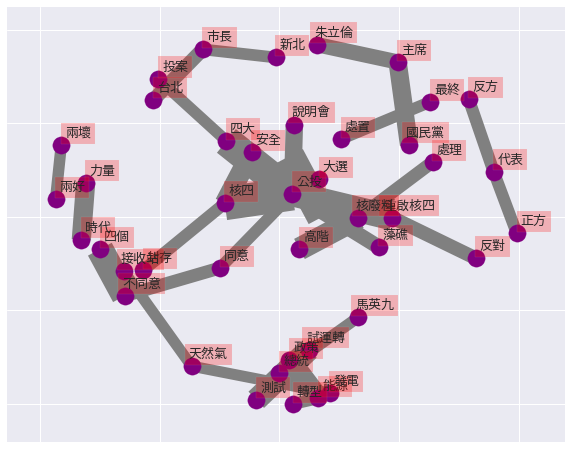

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

pos = nx.spring_layout(G, k=2)

# networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=weights,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.show()

由以上Bigram視覺化可得出，網民發表的字詞多數圍繞在"公投+大選"、"核四+公投"、"四大+公投"，因而在話題與繪圖中心點；另外"能源+轉型、發電、天然氣測試也是另一討論的核心點"。

### Pairwise correlation

計算兩個詞彙間的相關性 Phi相關係數(Phi coefficient)

In [ ]:
#取常一起出現的bigram pair 前500筆
b = {k:v for k,v in bigramfdist.most_common(500)}
# b.items()

In [ ]:
#建立DataFrame
bigram_df = pd.DataFrame(columns=['word', 'word2','n'])
for k,v in b.items():
    bigram_df = bigram_df.append({'word':k[0], 'word2':k[1], 'n':v}, ignore_index=True)

In [ ]:
#計算phi值
def phi_cor(df):
    #total x
    nx = len(set(word_count2[word_count2["word"]==df["word"]]["artUrl"]))
    tnx = len(MetaData)-nx
    #total y
    ny = len(set(word_count2[word_count2["word"]==df["word2"]]["artUrl"]))
    tny = len(MetaData)-ny
    #有x 有y
    x_ls = list(word_count2[word_count2["word"]==df["word"]]["artUrl"]) #單獨有x
    y_ls = list(word_count2[word_count2["word"]==df["word2"]]["artUrl"]) #單獨有y
    nxy = len(set(x_ls)&set(y_ls)) #取交集
    #有x 沒有y
    nxo = nx-nxy
    #沒有x 沒有y
    uxy = set(x_ls)|set(y_ls) #取聯集
    noo = len(set(list(MetaData["artUrl"]))-uxy) #取差集:全-有x有y
    #沒有x 有y
    noy = ny-nxy
    #print(nx,ny,tny,tnx,nxy,noo,nxo,noy)
    phi = (nxy*noo-nxo*noy)/math.sqrt(nx*ny*tny*tnx)
    
    return phi

In [ ]:
bigram_df["cor"] = bigram_df.apply(phi_cor, axis=1)
bigram_df = bigram_df[bigram_df["word"]!=bigram_df["word2"]]

下表可得知"公投+大選"出現次數最多，相關係數也最高，而值得注意的是"四個+不同意"在bigram出現頻率也是在第四高，相關係數同樣也很接近"公投+大選"。似乎網民言論偏向不同意，比起"四個+同意"更加受矚目。

In [ ]:
bigram_df

,word,word2,n,cor
0,公投,大選,230,0.489307
1,核四,公投,112,0.203195
2,四大,公投,101,0.301255
3,四個,不同意,90,0.443363
4,重啟核四,公投,85,0.373612
...,...,...,...,...
495,前應,完成,8,0.169315
496,龍門,電廠,8,0.178602
497,全線,潰堤,8,1.000000
498,支持,核電,7,0.048989


**同意、不同意之相關性最高的 15 個詞彙**

實際上出現相關性最高的約有各6、7個詞彙，當中包含重啟核四與不同意之相關性，比起核四與同意還要高。

In [ ]:
c_sum = bigram_df[(bigram_df["word"]=="同意")].sort_values(by=['cor'], ascending = False).head(15)
b_sum = bigram_df[(bigram_df["word"]=="不同意")].sort_values(by=['cor'], ascending = False).head(15)

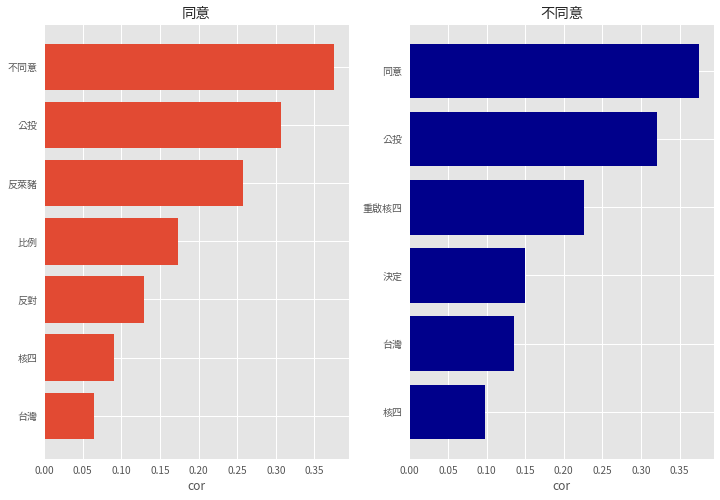

In [ ]:
c_sum = c_sum.sort_values(by=['cor'])
b_sum = b_sum.sort_values(by=['cor'])

plt.figure(figsize=(12,8))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式
# plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示

plt.subplot(121)
plt.title('同意')
plt.xlabel('cor')
plt.barh(c_sum['word2'],c_sum['cor'])

plt.subplot(122)
plt.title('不同意')
plt.xlabel('cor')
plt.barh(b_sum['word2'],b_sum['cor'],color="darkblue")


plt.show()

In [ ]:
bigram_df[bigram_df["cor"]>0.4]

,word,word2,n,cor
0,公投,大選,230,0.489307
3,四個,不同意,90,0.443363
6,試運轉,測試,75,0.595051
7,能源,政策,72,0.524181
9,時代,力量,64,0.541634
...,...,...,...,...
462,奇異,公司,8,0.435737
467,流言,終結者,8,0.934985
492,查核,四弊,8,0.731777
494,裝填,前應,8,0.665753


In [ ]:
word_cors = bigram_df[bigram_df["cor"]>0.4]
word_cors.reset_index(inplace=True, drop=True)

In [ ]:
import networkx as nx
# Create network plot 
g = nx.Graph()

# 建立 nodes 間的連結
for i in range(len(word_cors)):
    g.add_edge(word_cors["word"][i], word_cors["word2"][i], weight=word_cors["cor"][i])
    
# 取得edge權重
weights = [w[2]['weight']*10 for w in  g.edges(data=True)]

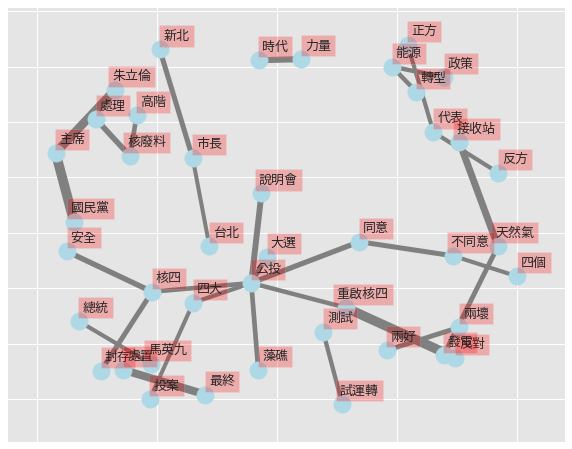

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

pos = nx.spring_layout(G, k=2)

# networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=weights,
                 edge_color='grey',
                 node_color='lightblue',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.show()

- 文章相似度   
以TF-IDF的結果當作文章的向量，計算 Cosine Similarity 找出相似的文章

In [ ]:
data_cos= MetaData.copy()
data_cos = data_cos.loc[:,["artTitle","artDate","artUrl","sentence"]]
# 需要改成使用空格連接斷好的詞
data_cos['word'] = data_cos.sentence.apply(getToken).map(' '.join)

In [ ]:
# Bag of Word
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data_cos["word"])
vocabulary = vectorizer.get_feature_names()
# 轉成dataframe
DTM_df = pd.DataFrame(columns = vocabulary, data = X.toarray())
DTM_df.head()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,一一,一三廠,一上台,一下,一下子,一不小心,一中,一乾二淨,一事,一事無成,一二,一二三,一二三四,一些,一人,一人毀,一代,一代人,一件,一任,一份,一位,一併,一個三十,一個個,一個多月,一個月,一個樣,一個願打,一個願挨,一倍,一億,一八,一六,一共,一再,一再強調,一出,一刀,一分,...,黨派,黨產,黨用,黨的基本,黨的政策,黨禁,黨立委,黨章,黨籍,黨紀,黨給,黨綱,黨職,黨衛軍,黨記,黨證,黨護藻,黨辦,黨部,黨黨,鼓動,鼓勵,鼓吹,鼻子,鼻子走,鼻酸,齊力,齊發,齊聲,齡李煥,龍岡,龍洞,龍潭,龍潭區,龍門,龍頭,龐大,龜兒子,龜山島,龜步
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
transformer = TfidfTransformer()  
print(transformer) 
#將詞頻矩陣X統計成TF-IDF值
tfidf = transformer.fit_transform(X)  
# print(tfidf.toarray())

# 轉成dataframe
TFIDF_df = pd.DataFrame(columns = vocabulary, data = tfidf.toarray())
TFIDF_df.head()

TfidfTransformer()


,一一,一三廠,一上台,一下,一下子,一不小心,一中,一乾二淨,一事,一事無成,一二,一二三,一二三四,一些,一人,一人毀,一代,一代人,一件,一任,一份,一位,一併,一個三十,一個個,一個多月,一個月,一個樣,一個願打,一個願挨,一倍,一億,一八,一六,一共,一再,一再強調,一出,一刀,一分,...,黨派,黨產,黨用,黨的基本,黨的政策,黨禁,黨立委,黨章,黨籍,黨紀,黨給,黨綱,黨職,黨衛軍,黨記,黨證,黨護藻,黨辦,黨部,黨黨,鼓動,鼓勵,鼓吹,鼻子,鼻子走,鼻酸,齊力,齊發,齊聲,齡李煥,龍岡,龍洞,龍潭,龍潭區,龍門,龍頭,龐大,龜兒子,龜山島,龜步
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.105678,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# 計算 cosine_similarity
def cosine_similarity(vector):
    cos_list = []
    for i in tfidf.toarray():
        score = np.dot(vector, i)  / (norm(vector) * norm(i))
        cos_list.append(score)
    df = pd.DataFrame(cos_list, columns=["cos_similarity"])
    return df

In [ ]:
print(tfidf.toarray()[1])
cos_df = cosine_similarity(tfidf.toarray()[1])

[0. 0. 0. ... 0. 0. 0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


In [ ]:
# 找和第一篇文章相似的其他文章
cos_df = cos_df.merge(data_cos, how = 'left', left_index=True, right_index=True)
# cos_df.head()
cos_df.loc[:,["cos_similarity","artTitle"]].sort_values(by=['cos_similarity'], ascending=False).head(10)

,cos_similarity,artTitle
1,1.000000,[黑特]誰能告訴我反對核四的理由到底是什麼
486,0.139427,[討論]為什麼有支持核能保環礁，或是相反得選
262,0.094848,[新聞]藻礁公投在即經濟部：北部要用電三接是
472,0.087297,[討論]台中跟高雄人支持核四嗎？
370,0.070101,[新聞]發生核災「台北就完了」柯文哲表態：個
670,0.066658,[新聞]民進黨立委邱議瑩：台積電要來高雄設廠
383,0.065938,[新聞]鄭文燦批四公投是害台灣三接不蓋台灣會
470,0.065709,[討論]朱立倫2015年公開宣示2025非核家園
97,0.065606,[新聞]焦糖哥哥喊話公投四個不同意「教訓不到
695,0.065484,[黑特]國民黨到底能幹嘛?


## 文件分類

**套件說明**

下面列出在本次實作過程中我們所使用到的相關套件，在這個Jupyter Notebook當中我們

將會簡單的展示這些套件的使用方式，關於各個套件的進階使用請同學參照其官網的說
明。

pandas: 一個資料分析的函式庫，提供了DataFrame等資料格式，與資料處理的函數。

NLTK: 全名為Natural Language Tool Kit，自然語言處理工具。

sklearn: 全名為Scikit-learn，機器學習的常用建模套件，包含各種分群、分類、迴歸模型，如隨機森林、SVM或 K-means 等。
jieba: 結巴套件，中文斷詞套件

seaborn: 基於 matplotlib 封裝的繪圖工具

time: 獲得目前的時間或作時間格式轉換的工具

In [ ]:
import pandas as pd
import re
import time
import string
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import jieba

import nltk
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn import metrics, model_selection, feature_extraction
from sklearn import feature_extraction, model_selection, naive_bayes,pipeline,\
manifold, preprocessing, feature_selection, metrics, svm, tree, ensemble
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression

In [ ]:
# cloab 字體設定
!wget -O taipei_sans_tc_beta.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download

# 新增字體
matplotlib.font_manager.fontManager.addfont('taipei_sans_tc_beta.ttf')

# 將 font-family 設為 Taipei Sans TC Beta
# 設定完後，之後的圖表都可以顯示中文了
matplotlib.rc('font', family='Taipei Sans TC Beta')

--2021-12-05 15:02:46--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 172.217.4.174, 2607:f8b0:4007:80e::200e
Connecting to drive.google.com (drive.google.com)|172.217.4.174|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/k79so42f26mg5d72493ovolr4b52an7d/1638716550000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_ [following]
--2021-12-05 15:02:47--  https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/k79so42f26mg5d72493ovolr4b52an7d/1638716550000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving doc-0k-9o-docs.googleusercontent.com (doc-0k-9o-docs.googleusercontent.com)... 142.250.72.225, 2607:f8b0:4007:816::2001
Connecting to doc-0k-9o-docs.googleusercontent.com (doc-0k-9o-docs.googleusercontent.com)|142.250.72.225|:4

**文字前處理**

PTT_核四Politics_articleMetaData.csv裡面包含了要分析的ptt文章資料，在這邊我們先

把句子斷開，一個句子代表一個文件(document)，因為每個document需要標上不同的情緒

標籤，我們先將每個句子斷詞並用liwc算出情緒分數，為了後面建立 DTM

(document-term-matrix) 我們先清理停用字和詞頻太少的句子，並做基本的文件探索。

In [ ]:
books = pd.read_csv("/content/drive/MyDrive/ColabNotebooks/Colab_Notebooks_study/公投/公投rawdata政黑/PTT_核四Politics_articleMetaData.csv") #匯資料
books.head(3)

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence
0,[新聞]中國忌憚美英澳核潛艇合作王毅：五重危,2021/10/01,01:02:45,https://www.ptt.cc/bbs/HatePolitics/M.16330501...,starport,HatePolitics,11,5,1,中國忌憚美英澳核潛艇合作 王毅：五重危害\nhttps://bit.ly/3A9dm2d\n...
1,[轉錄]中正紀念堂銅像拆了以後要放什麼？,2021/10/01,06:24:44,https://www.ptt.cc/bbs/HatePolitics/M.16330694...,twoquarters,HatePolitics,20,8,1,1.轉錄網址：\nhttps://bit.ly/39WjFvk\n2.轉錄來源︰\nThe ...
2,[新聞]1個月停電3次!陳其邁震怒批台電「落漆」,2021/10/01,10:52:49,https://www.ptt.cc/bbs/HatePolitics/M.16330855...,jason486,HatePolitics,9,6,0,1個月停電3次!陳其邁震怒批台電「落漆」 黃捷:鳳山民怨已深\n\n新頭殼newtalk |...


In [ ]:
# 看看有幾篇文章
print(f"number of posts: {books.shape[0]}")

number of posts: 2043


**文字前處理**

*    斷句
*    斷詞（刪掉次數太少的、標點符號、停用字）
*   算出情緒分數，將正負面文章分類
*   將情緒標籤加回原本的資料集




    
    
    

  **斷句**

    利用問號、句號或驚嘆號等符號斷句，或是如果出現中文或是英文的省略號，像是...也會斷句，最後設定會去除結尾的空白符號。

In [ ]:
def cut_sent(para):
    para = re.sub('([。！？\?])([^”’])', r"\1\n\2", para)  # 斷句符號
    para = re.sub('(\.{6})([^”’])', r"\1\n\2", para)  # 英文省略號
    para = re.sub('(\…{2})([^”’])', r"\1\n\2", para)  # 中文省略號
    para = re.sub('([。！？\?][”’])([^，。！？\?])', r'\1\n\2', para)
    para = para.rstrip()  # 去掉句尾多餘的空白
    para = re.split("\r|[\n]+",para) # 找到一個或多個\n都可以斷句
    para_list = list(filter(None, para))
    return para_list 

文章的標題artTitle和內文sentence都會納入分析的內容，成為新的content欄位。

In [ ]:
# 篩選需要的欄位
books['content'] = books['artTitle'] + books['sentence']
books = books.dropna() #去掉空白欄位
data = books[['content','artUrl']] #文章內容 文章連結data.head(3)

# 把句子切開
data['sentence'] = data.apply(lambda row : cut_sent(row['content']), axis=1) #把句子切開
data = data[['sentence','artUrl']].explode("sentence")
data['document'] = range(0, len(data))
data.head(3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,sentence,artUrl,document
0,[新聞]中國忌憚美英澳核潛艇合作王毅：五重危中國忌憚美英澳核潛艇合作 王毅：五重危害,https://www.ptt.cc/bbs/HatePolitics/M.16330501...,0
0,https://bit.ly/3A9dm2d,https://www.ptt.cc/bbs/HatePolitics/M.16330501...,1
0,中央社記者邱國強北京,https://www.ptt.cc/bbs/HatePolitics/M.16330501...,2


In [ ]:
# 看看有幾個句子
print(f"total sentences: {data.shape[0]}")

total sentences: 47750


**斷詞**
*   進行斷詞
        去除標點符號
        去除stopwords
        篩選出現太少次的字

In [ ]:
def load_stop_words(path):
    with open(path) as f:
        stopWords = [line.strip() for line in f.readlines()]
    return stopWords

def get_tokens(sent,user_dict,stop_dict):
    
    # 去除noise 斷詞
    jieba.load_userdict(user_dict) # 客製化字典    
    sent = re.sub('[^\u4e00-\u9fa5]+', '', sent) # 過濾標點符號、英文、數字，只留中文
    words = list(jieba.cut(sent)) # 斷詞

    #去除停用字
    stopWords = load_stop_words(stop_dict)    
    words = [w for w in words if w not in stopWords and len(w) > 1] # 字詞長度要>1
    return " ".join(words)

In [ ]:
# 這裡會跑比較久
stop_path = '/content/drive/MyDrive/ColabNotebooks/Colab_Notebooks_study/公投/文件分析dict/stop_words.txt'
user_path = "/content/drive/MyDrive/ColabNotebooks/Colab_Notebooks_study/公投/文件分析dict/user_dict.txt"

# 把句子切開，待會丟DTM
data['clean_txt'] = data.apply(lambda row : get_tokens(row['sentence'],user_path,stop_path), axis=1) 
data.head(5)

,sentence,artUrl,document,clean_txt
0,[新聞]中國忌憚美英澳核潛艇合作王毅：五重危中國忌憚美英澳核潛艇合作 王毅：五重危害,https://www.ptt.cc/bbs/HatePolitics/M.16330501...,0,中國 忌憚 美英 核潛艇 合作 王毅 五重 中國 忌憚 美英 核潛艇 合作 王毅 五重 危害
0,https://bit.ly/3A9dm2d,https://www.ptt.cc/bbs/HatePolitics/M.16330501...,1,
0,中央社記者邱國強北京,https://www.ptt.cc/bbs/HatePolitics/M.16330501...,2,中央社 記者 國強 北京
0,美英澳合組AUKUS聯盟及核潛艇技術合作，引起中國強烈反彈。,https://www.ptt.cc/bbs/HatePolitics/M.16330501...,3,美英 合組 聯盟 核潛艇 技術 合作 引起 中國 強烈 反彈
0,中國國務委員兼外長王毅,https://www.ptt.cc/bbs/HatePolitics/M.16330501...,4,中國 國務委員 外長 王毅


In [ ]:
# 把字詞斷開，待會情緒分析
token_df = data[['document','clean_txt']]
token_df["word"] = data["clean_txt"].str.split(" ") # 將句子用空白切成list
token_df = token_df[['document','word']].explode("word").reset_index(drop=True) # 把切開的list展開
token_df.head(5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,document,word
0,0,中國
1,0,忌憚
2,0,美英
3,0,核潛艇
4,0,合作


In [ ]:
# 看看有幾個詞
print(f"unique words: {len(token_df.word.unique())}")

unique words: 32252


**算出情緒分數，將正負面文章分類**

    1. 待會分類任務要用的
    2. 用 week4 的 liwc 字典
    3. 讀入liwc的字典，轉換成dataframe

In [ ]:
# 參考 week4 code
def load_senti():
    filepath = ['negative','positive']
    d_liwc = []
    for file in filepath:
        filename = f"/content/drive/MyDrive/ColabNotebooks/Colab_Notebooks_study/公投/文件分析dict/liwc/{file}.txt"
        with open(filename, 'r', encoding='UTF-8-sig') as f:
            d_liwc.append([f.read().split(","),file])
    df_liwc = pd.DataFrame(d_liwc,columns = ['word','sentiments']).explode('word',ignore_index = True)    
    df_liwc['word'] = df_liwc['word'].str.replace('"\n','')
    
    return df_liwc

用 load_senti 獲得情緒字典的 dataframe，可以自行調整加上新的正面或負面詞彙

In [ ]:
# 獲得情緒字典
data_liwc = load_senti() 

# 新增的負面詞
neg_added = ["塔綠班","塔綠斑","不同意"] 
for w in neg_added:
    data_liwc.loc[-1] = [w, "negative"]
    data_liwc.index = data_liwc.index + 1
    data_liwc = data_liwc.sort_index()

#pos_added = ["省錢","重啟","同意"] 
#for w in pos_added:
 #   data_liwc.loc[-1] = [w, "positive"]
  #  data_liwc.index = data_liwc.index + 1
   # data_liwc = data_liwc.sort_index()  
     
data_liwc.head(20)

,word,sentiments
0,不同意,negative
1,塔綠斑,negative
2,塔綠班,negative
3,怪別人,negative
4,激進,negative
5,違反,negative
6,怪世界,negative
7,怪地球,negative
8,蓋牌,negative
9,吞下去,negative


將剛剛字詞斷開後的token_df和df_liwc合併，算出每個詞的情緒，得到senti_count資料框。

In [ ]:
# 統計文章情緒
senti_df = pd.merge(token_df, data_liwc, on=['word'],how='inner') # token和情緒字典做merge
senti_count = senti_df.groupby(['document','sentiments'],as_index=False).size() # 算出每篇文章的情緒
senti_count = senti_count.pivot(index='document',columns='sentiments',values='size').fillna(0) # 把資料展開，缺值補零
senti_count = senti_count.reset_index().rename_axis(None, axis=1) # 把兩個level變成一層level

# 幫文章加上標籤
senti_count['label'] = np.where(senti_count['positive'] >= senti_count['negative'], 'pos','neg')
senti_count.head(5)

,document,negative,positive,label
0,3,1.0,0.0,neg
1,13,1.0,0.0,neg
2,16,3.0,0.0,neg
3,21,0.0,1.0,pos
4,23,2.0,0.0,neg


**將情緒標籤加回原本的資料集**

    1.把情緒標籤加回去
    2.如果該篇文章沒有情緒字，就算是中性的文章
將剛剛得到的senti_count資料框和一開始的data資料集合併，得到每句話的情緒。

In [ ]:
# token和情緒字典做merge
data_senti = pd.merge(data, senti_count[['document','label']], on=['document'],how='left').fillna('neu') 
data_senti.head(10)

,sentence,artUrl,document,clean_txt,label
0,[新聞]中國忌憚美英澳核潛艇合作王毅：五重危中國忌憚美英澳核潛艇合作 王毅：五重危害,https://www.ptt.cc/bbs/HatePolitics/M.16330501...,0,中國 忌憚 美英 核潛艇 合作 王毅 五重 中國 忌憚 美英 核潛艇 合作 王毅 五重 危害,neu
1,https://bit.ly/3A9dm2d,https://www.ptt.cc/bbs/HatePolitics/M.16330501...,1,,neu
2,中央社記者邱國強北京,https://www.ptt.cc/bbs/HatePolitics/M.16330501...,2,中央社 記者 國強 北京,neu
3,美英澳合組AUKUS聯盟及核潛艇技術合作，引起中國強烈反彈。,https://www.ptt.cc/bbs/HatePolitics/M.16330501...,3,美英 合組 聯盟 核潛艇 技術 合作 引起 中國 強烈 反彈,neg
4,中國國務委員兼外長王毅,https://www.ptt.cc/bbs/HatePolitics/M.16330501...,4,中國 國務委員 外長 王毅,neu
5,29日聲稱，,https://www.ptt.cc/bbs/HatePolitics/M.16330501...,5,聲稱,neu
6,美英澳核潛艇技術合作將為亞太帶來「五重危害」,https://www.ptt.cc/bbs/HatePolitics/M.16330501...,6,美英 核潛艇 技術 合作 將為 亞太 帶來 五重 危害,neu
7,，包括誘發新一輪軍備競賽,https://www.ptt.cc/bbs/HatePolitics/M.16330501...,7,包括 誘發 新一輪 軍備競賽,neu
8,。,https://www.ptt.cc/bbs/HatePolitics/M.16330501...,8,,neu
9,AUKUS組成及宣示核潛艇技術合作，被普遍認為踩到中國痛腳，,https://www.ptt.cc/bbs/HatePolitics/M.16330501...,9,組成 宣示 核潛艇 技術 合作 普遍 認為 踩到 中國 痛腳,neu


**資料集基本檢視**

    檢視資料內容

In [ ]:
print(f"total posts: {len(data_senti.artUrl.unique())}")
print(f"total sentences: {len(data_senti.document.unique())}")

total posts: 2042
total sentences: 47750


In [ ]:
# 算兩種資料框的字頻
word_count = (pd.merge(token_df, data_senti[['document','label']], 
                  on=['document'],how='left') 
                 .groupby(['label','word'], as_index=False).size()
                 .sort_values(by=['label','size'], ascending=False))
word_count.head(5)

,label,word,size
36606,pos,公投,866
40992,pos,核四,735
40175,pos,支持,721
37496,pos,同意,678
37388,pos,台灣,469


In [ ]:
# 選出兩類文章最高的20個字
top_n = 20
book1 = word_count[word_count["label"]=="neg"].head(top_n).sort_values(by=['size']) # 負面情緒 
book2 = word_count[word_count["label"]=="pos"].head(top_n).sort_values(by=['size']) # 正面情緒
book1.head(5)

,label,word,size
3838,neg,恐嚇,99
2827,neg,大選,101
7575,neg,萊豬,103
7543,neg,英文,106
7690,neg,藻礁,108


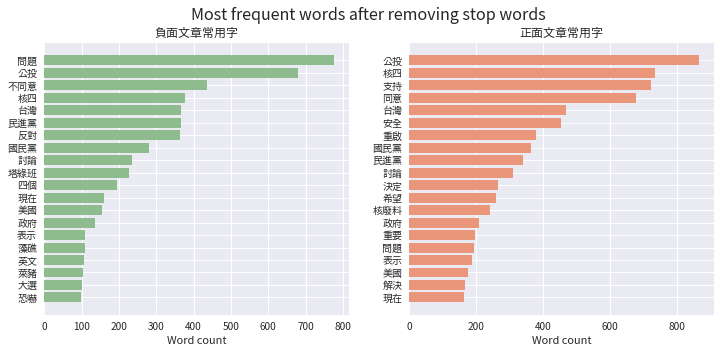

In [ ]:
from matplotlib.font_manager import FontProperties

plt.figure(figsize=(12,5))   
plt.style.use('seaborn') 
plt.rcParams['font.sans-serif']=['Taipei Sans TC Beta'] #使圖中中文能正常顯示
matplotlib.rc('font', family='Taipei Sans TC Beta')
plt.subplot(121)
plt.title('負面文章常用字')
plt.xlabel('Word count')
plt.barh(book1['word'],book1['size'],color="darkseagreen")

plt.subplot(122)
plt.title('正面文章常用字')
plt.xlabel('Word count')
plt.barh(book2['word'],book2['size'],color="darksalmon")

# 最上面的標題
plt.suptitle('Most frequent words after removing stop words', fontsize=16)
plt.show()

正面文章常用字有支持、同意、安全、重啟、希望等；而負面文章常用字有不同意、反對、塔綠班、恐嚇等。而「台灣」、「公投」則因為是話題焦點，在兩邊的文章都頻繁出現。

### 將資料切成訓練集與測試集

**根據7:3的比例切分資料集**

利用 sklearn 中的 train_test_split 函數將 raw_data 隨機切成 7:3，設置 random_state 讓每次切分的結果一致。y_train和y_test分別為訓練資料和測試資料的預測目標（每個句子所屬的書名id）。

In [ ]:
# 把整個資料集七三切
dtf_train, dtf_test = model_selection.train_test_split(data_senti, stratify=data_senti["label"],
                                                       test_size=0.3, random_state=2021)
## get target
y_train = dtf_train["label"].values
y_test = dtf_test["label"].values

In [ ]:
#看一下各個資料集切分的比例，應該要一致
print(f"raw data percentage :\n{data_senti['label'].value_counts(normalize=True) * 100}")
print(f"\ntrain percentage :\n{dtf_train['label'].value_counts(normalize=True) * 100}")
print(f"\ntest percentage :\n{dtf_test['label'].value_counts(normalize=True) * 100}")


raw data percentage :
neu    74.211518
pos    14.188482
neg    11.600000
Name: label, dtype: float64

train percentage :
neu    74.210920
pos    14.189978
neg    11.599102
Name: label, dtype: float64

test percentage :
neu    74.212914
pos    14.184991
neg    11.602094
Name: label, dtype: float64


### 將文章轉為 DTM

套入正式的資料集

模型訓練範例: logistic regression + cv tokenize

In [ ]:
## 定義切分資料的 vectorizer
# Count (classic BoW) 
cv_vectorizer = feature_extraction.text.CountVectorizer(max_features=10000)  # , ngram_range=(1,2)
cv_vectorizer_min = feature_extraction.text.CountVectorizer(max_features=10000,min_df = 10) # , ngram_range=(1,2)

# # Tf-Idf (advanced variant of BoW)
# tfidf_vectorizer = feature_extraction.text.TfidfVectorizer(max_features=100) # , ngram_range=(1,2)

In [ ]:
corpus = dtf_train["clean_txt"]


過濾詞頻比較

In [ ]:
# 沒有過濾最低詞頻的 vectorizer
cv_vectorizer.fit(corpus)
X_train = cv_vectorizer.transform(corpus)
vocabulary = cv_vectorizer.get_feature_names()

# 過濾至少要出現10次 vectorizer
cv_vectorizer_min.fit(corpus)
X_train_min = cv_vectorizer_min.transform(corpus)
vocabulary_min = cv_vectorizer_min.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
print(f"without term cut off: posts {X_train.shape[0]} words: {X_train.shape[1]} ({len(vocabulary)})") 
print(f"with term cut off: posts {X_train_min.shape[0]} words: {X_train_min.shape[1]} ({len(vocabulary_min)})") 
X_train

without term cut off: posts 33425 words: 10000 (10000)
with term cut off: posts 33425 words: 2447 (2447)


<33425x10000 sparse matrix of type '<class 'numpy.int64'>'
	with 133729 stored elements in Compressed Sparse Row format>

In [ ]:
# 定義分類器模型
classifier = LogisticRegression(multi_class='multinomial', solver='lbfgs')

In [ ]:
# 定義模型訓練組合

## pipeline: 分類器 + 資料處理 vectorizer
model = pipeline.Pipeline([("vectorizer", cv_vectorizer),  
                           ("classifier", classifier)])
## train classifier
model["classifier"].fit(X_train, y_train)

## test
X_test = dtf_test["clean_txt"].values
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Accuracy: 0.96
Auc: 0.98
Detail:
              precision    recall  f1-score   support

         neg       0.97      0.79      0.87      1662
         neu       0.95      1.00      0.98     10631
         pos       0.99      0.90      0.94      2032

    accuracy                           0.96     14325
   macro avg       0.97      0.90      0.93     14325
weighted avg       0.96      0.96      0.96     14325



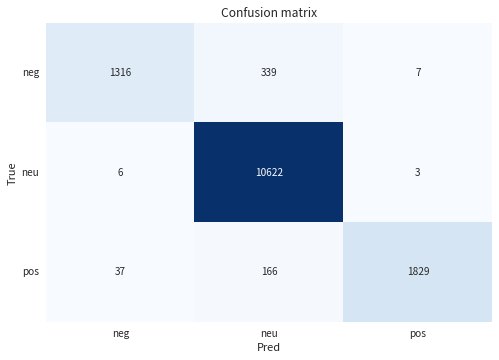

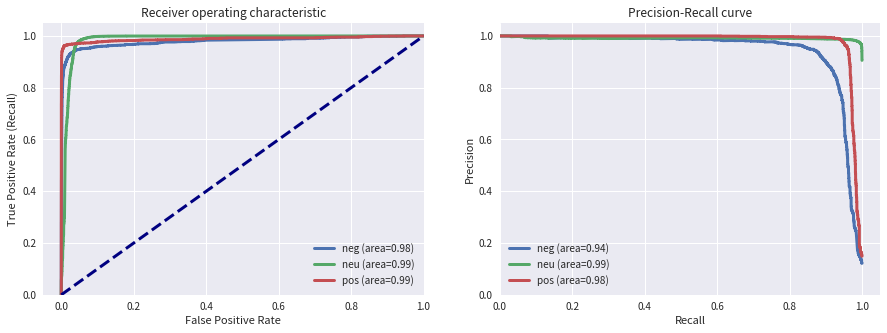

In [ ]:
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values

## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test_array, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

In [ ]:
# 定義模型訓練組合

## pipeline: 分類器 + 資料處理 vectorizer
model = pipeline.Pipeline([("vectorizer", cv_vectorizer_min),  
                           ("classifier", classifier)])
## train classifier
model["classifier"].fit(X_train_min, y_train)

## test
X_test = dtf_test["clean_txt"].values
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Accuracy: 0.95
Auc: 0.95
Detail:
              precision    recall  f1-score   support

         neg       0.95      0.74      0.83      1662
         neu       0.95      1.00      0.97     10631
         pos       0.99      0.89      0.94      2032

    accuracy                           0.95     14325
   macro avg       0.96      0.87      0.91     14325
weighted avg       0.95      0.95      0.95     14325



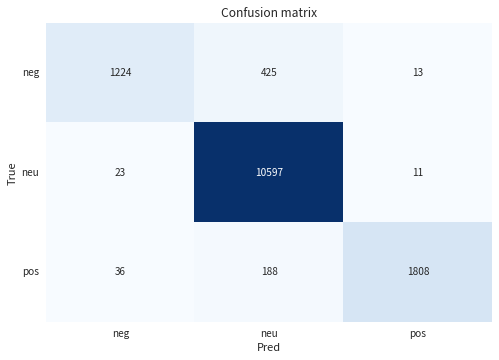

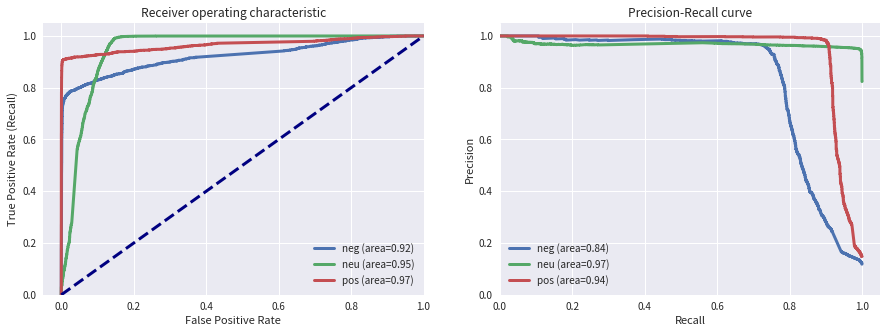

In [ ]:
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values

## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test_array, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

**定義建模與畫圖的函數**

因為不同的 classifier 可以和不同的 vectorizer 搭配，為了簡化程式，我們將建模與畫圖的步驟定義成函數

In [ ]:
def model_predict(train_data, test_data, train_label, vectorizer, classifier, return_classifier = False):
    
    start = time.time()

    # sentence to DTM
    vectorizer.fit(train_data) # fit(corpus)
    X_train = vectorizer.transform(corpus)    
    
    ## pipeline: 分類器 + 資料處理 vectorizer
    model = pipeline.Pipeline([("vectorizer", vectorizer),  
                               ("classifier", classifier)])
    ## train classifier
    model["classifier"].fit(X_train, train_label)
    
    ## test
    X_test = test_data.values
    predicted = model.predict(X_test)
    predicted_prob = model.predict_proba(X_test)
    
    end = time.time()
    print(f"time costing: {end - start}")
    
    if return_classifier:
        return predicted, predicted_prob, classifier       
    else:
        return predicted, predicted_prob

In [ ]:
def evaluate(true, predicted, predicted_prob):

    classes = np.unique(true)
    true_array = pd.get_dummies(true, drop_first=False).values

    ## Accuracy, Precision, Recall
    Accuracy = metrics.accuracy_score(true, predicted)
    AUC = metrics.roc_auc_score(true_array, predicted_prob, 
                                multi_class="ovr")
    
    print("Accuracy:",  round(Accuracy,2))
    print("Auc:", round(AUC,2))
    print("Detail:")
    print(metrics.classification_report(true, predicted))
    
    ## Plot confusion matrix
    cm = metrics.confusion_matrix(true, predicted)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
                cbar=False)
    ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
           yticklabels=classes, title="Confusion matrix")
    plt.yticks(rotation=0)

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

    ## Plot roc
    roc_auc_dict = {}
    for i in range(len(classes)):
        fpr, tpr, thresholds = metrics.roc_curve(true_array[:,i],  
                               predicted_prob[:,i])
        roc_auc = metrics.auc(fpr, tpr)
        ax[0].plot(fpr, tpr, lw=3, 
                  label='{0} (area={1:0.2f})'.format(classes[i], roc_auc)
                   )
        roc_auc_dict[classes[i]] = {"fpr":fpr,"tpr": tpr, "roc_auc": roc_auc} 
        
    ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
    ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
              xlabel='False Positive Rate', 
              ylabel="True Positive Rate (Recall)", 
              title="Receiver operating characteristic")
    ax[0].legend(loc="lower right")
    ax[0].grid(True)

    ## Plot precision-recall curve
    for i in range(len(classes)):
        precision, recall, thresholds = metrics.precision_recall_curve(
                     true_array[:,i], predicted_prob[:,i])
        ax[1].plot(recall, precision, lw=3, 
                   label='{0} (area={1:0.2f})'.format(classes[i], 
                                      metrics.auc(recall, precision))
                  )
    ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
              ylabel="Precision", title="Precision-Recall curve")
    ax[1].legend(loc="best")
    ax[1].grid(True)
    plt.show()
    
    return Accuracy, AUC, roc_auc_dict

ROC 適用二元分類，故將每個類別(正面、中性、負面情緒)的預測都視作為一個二元分類，以下比較上面各模型的分類效果

**step 1 定義 vectorizer**

In [ ]:
cut_off = 0 # 經由實驗發現詞頻不篩模型會比較準，但需要較長的時間，同學可以自行取捨
vec_cv = feature_extraction.text.CountVectorizer(max_features=10000, min_df = cut_off) # , ngram_range=(1,2)
vec_tfidf = feature_extraction.text.TfidfVectorizer(max_features=10000, min_df = cut_off) # , ngram_range=(1,2)

**step 2 定義 classifier**

In [ ]:
cla_lg = LogisticRegression(multi_class='multinomial', solver='lbfgs')
cla_svc = svm.SVC(probability=True)
cla_rf  = ensemble.RandomForestClassifier()

**step 3 定義測試和訓練資料集**

In [ ]:
train_data = dtf_train["clean_txt"]
test_data = dtf_test["clean_txt"]
train_label = y_train
test_label = y_test

In [ ]:
## 創造一個空的dataframe 和 list 存模型結果
result_df = pd.DataFrame(columns=['model_type', 'Accuracy', 'AUC'])
roc_auc_all = {}

### 比較不同模型和資料組合的訓練結果

**Model Building : logistic regression**

logistic regression 原本是用來做二元分類的，如果要多元分類需要另外指定

model type: CV + logistic regression


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


time costing: 4.800153017044067
Accuracy: 0.96
Auc: 0.98
Detail:
              precision    recall  f1-score   support

         neg       0.97      0.79      0.87      1662
         neu       0.95      1.00      0.98     10631
         pos       0.99      0.90      0.94      2032

    accuracy                           0.96     14325
   macro avg       0.97      0.90      0.93     14325
weighted avg       0.96      0.96      0.96     14325



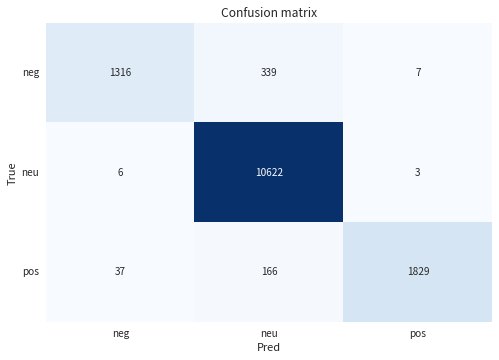

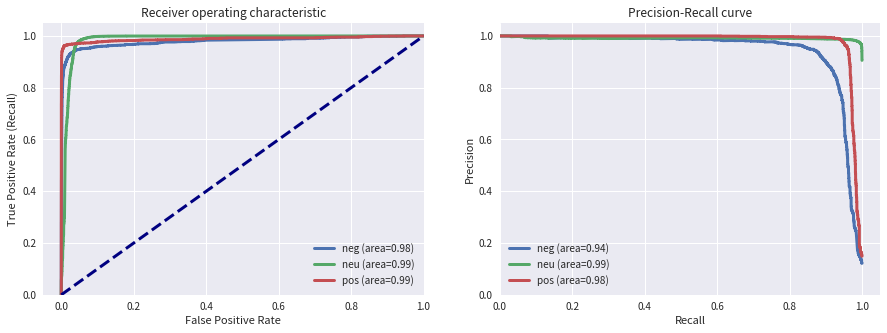

In [ ]:
model_type = "CV + logistic regression"
print(f"model type: {model_type}")
# 訓練模型
pred_l , pred_pro_l, logisticRegr = model_predict(dtf_train["clean_txt"], dtf_test["clean_txt"], y_train,
                                 vectorizer = vec_cv, classifier = cla_lg,
                                 return_classifier = True)
# 查看模型訓練結果
accuracy, auc, roc_auc = evaluate(test_label, pred_l, pred_pro_l)
# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc }
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

model type: TF-IDF + logistic regression


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


time costing: 4.94481635093689
Accuracy: 0.92
Auc: 0.98
Detail:
              precision    recall  f1-score   support

         neg       0.97      0.61      0.75      1662
         neu       0.91      1.00      0.95     10631
         pos       1.00      0.78      0.88      2032

    accuracy                           0.92     14325
   macro avg       0.96      0.80      0.86     14325
weighted avg       0.93      0.92      0.92     14325



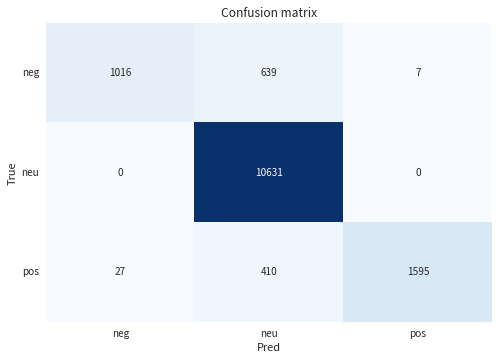

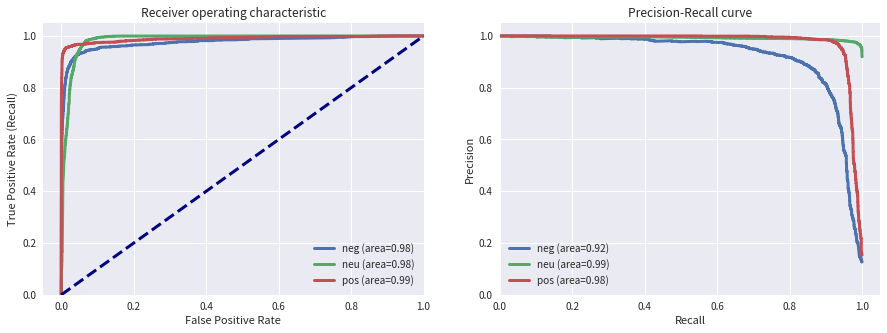

In [ ]:
model_type = "TF-IDF + logistic regression"
print(f"model type: {model_type}")

# 訓練模型
pred , pred_pro = model_predict(train_data, test_data, train_label,
                             vectorizer = vec_tfidf , classifier = cla_lg)
# 查看模型訓練結果
accuracy, auc, roc_auc = evaluate(test_label, pred, pred_pro)
# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc }
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

**Model Building : SVC**

model type: CV + SVC
time costing: 1321.8302116394043
Accuracy: 0.9
Auc: 0.98
Detail:
              precision    recall  f1-score   support

         neg       0.96      0.54      0.69      1662
         neu       0.89      1.00      0.94     10631
         pos       0.99      0.70      0.82      2032

    accuracy                           0.90     14325
   macro avg       0.95      0.75      0.82     14325
weighted avg       0.91      0.90      0.90     14325



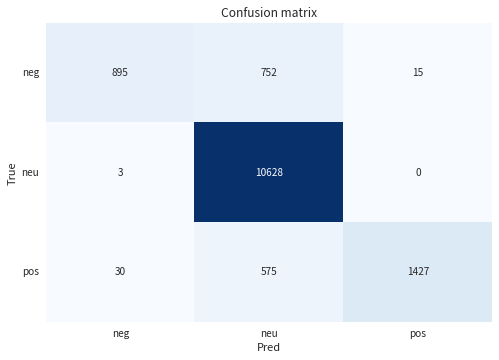

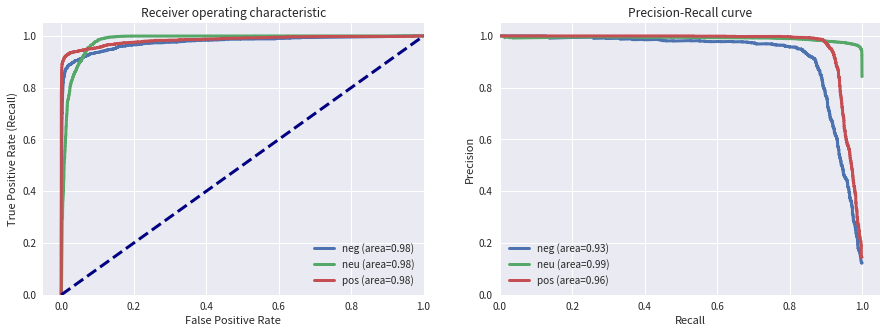

In [ ]:
model_type = "CV + SVC"
print(f"model type: {model_type}")
# 訓練模型
pred , pred_pro = model_predict(train_data, test_data, train_label,
                             vectorizer = vec_cv, classifier = cla_svc)
# 查看模型訓練結果
accuracy, auc, roc_auc = evaluate(test_label, pred, pred_pro)
# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc }
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

model type: TF-IDF + SVC
time costing: 1499.542227268219
Accuracy: 0.93
Auc: 0.99
Detail:
              precision    recall  f1-score   support

         neg       0.96      0.64      0.77      1662
         neu       0.92      1.00      0.96     10631
         pos       1.00      0.80      0.88      2032

    accuracy                           0.93     14325
   macro avg       0.96      0.81      0.87     14325
weighted avg       0.93      0.93      0.92     14325



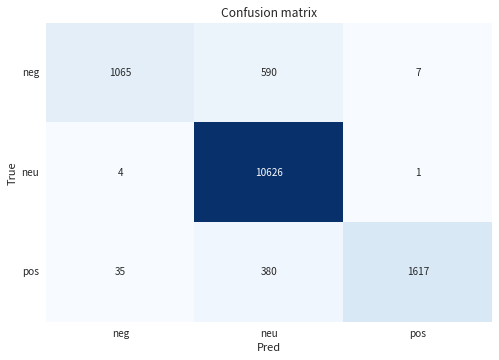

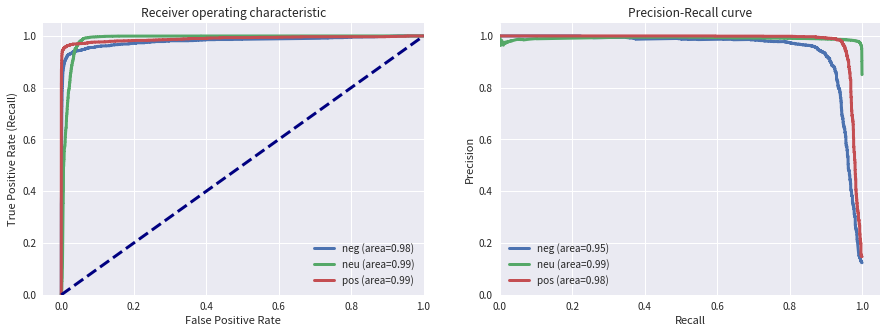

In [ ]:
model_type = "TF-IDF + SVC"
print(f"model type: {model_type}")
# 訓練模型
pred , pred_pro = model_predict(train_data, test_data, train_label,
                             vectorizer = vec_tfidf, classifier = cla_svc)
# 查看模型訓練結果
accuracy, auc, roc_auc = evaluate(test_label, pred, pred_pro)
# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc }
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

**Model Building : RandomForest**

model type: CV + RandomForest
time costing: 38.4206018447876
Accuracy: 0.98
Auc: 0.98
Detail:
              precision    recall  f1-score   support

         neg       0.96      0.90      0.92      1662
         neu       0.98      1.00      0.99     10631
         pos       0.98      0.93      0.95      2032

    accuracy                           0.98     14325
   macro avg       0.97      0.94      0.96     14325
weighted avg       0.98      0.98      0.98     14325



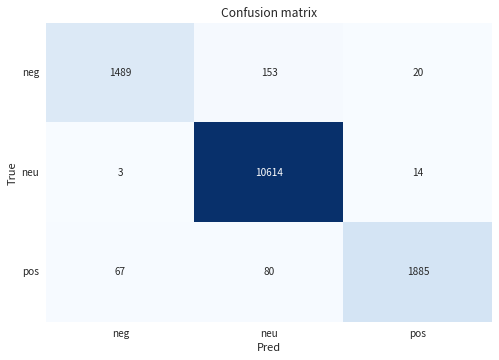

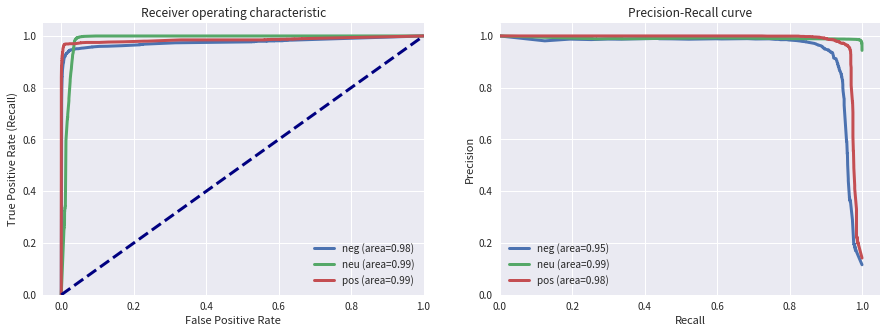

In [ ]:
model_type = "CV + RandomForest"
print(f"model type: {model_type}")
# 訓練模型
pred , pred_pro = model_predict(train_data, test_data, train_label,
                             vectorizer = vec_cv, classifier = cla_rf)
# 查看模型訓練結果
accuracy, auc, roc_auc = evaluate(test_label, pred, pred_pro)
# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc }
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

model type: TF-IDF + RandomForest
time costing: 37.94616627693176
Accuracy: 0.98
Auc: 0.98
Detail:
              precision    recall  f1-score   support

         neg       0.96      0.88      0.92      1662
         neu       0.98      1.00      0.99     10631
         pos       0.98      0.93      0.96      2032

    accuracy                           0.98     14325
   macro avg       0.97      0.94      0.95     14325
weighted avg       0.98      0.98      0.98     14325



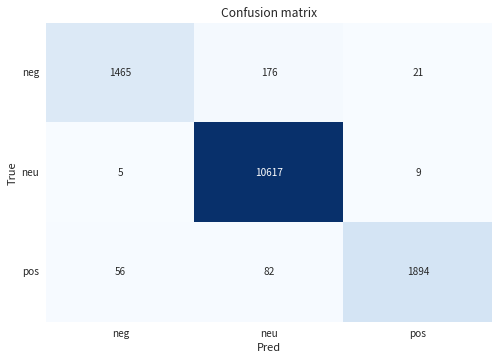

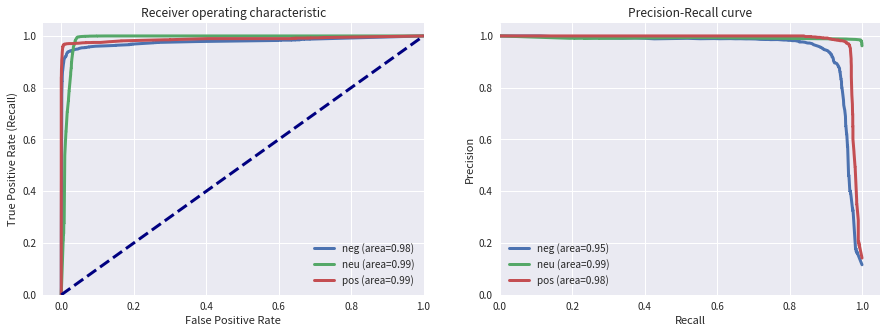

In [ ]:
model_type = "TF-IDF + RandomForest"
print(f"model type: {model_type}")
# 訓練模型
pred , pred_pro = model_predict(train_data ,test_data ,train_label,
                             vectorizer = vec_tfidf ,classifier = cla_rf)
# 查看模型訓練結果
accuracy, auc, roc_auc = evaluate(test_label, pred, pred_pro)
# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc }
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

**預測結果探索**

    各字詞特徵的estimate係數
    查看分類錯誤的句子
    比較不同模型的ROC

查看模型預測結果

In [ ]:
result_df.sort_values(by=['Accuracy'], ascending=False)

,model_type,Accuracy,AUC
4,CV + RandomForest,0.976475,0.982361
5,TF-IDF + RandomForest,0.975637,0.984241
0,CV + logistic regression,0.961047,0.984554
3,TF-IDF + SVC,0.929005,0.985591
1,TF-IDF + logistic regression,0.924398,0.983538
2,CV + SVC,0.904014,0.980880


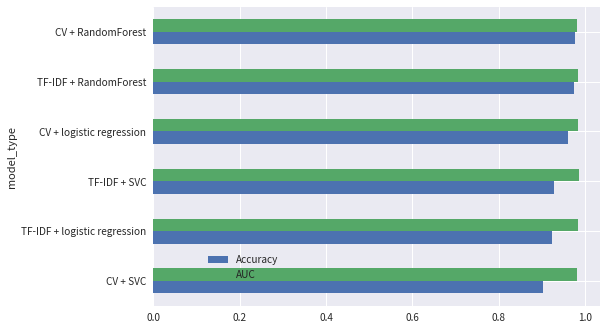

In [ ]:
result_df.sort_values(by=['Accuracy'], ascending=True) \
    .plot.barh(x="model_type", y=["Accuracy", "AUC"])
plt.legend(bbox_to_anchor=(0.3,0.2))

**各字詞特徵的estimate係數**

對於線性的模型，可以藉由相關係數，查看資料特徵（詞）對於判斷分類的影響


In [ ]:
def plot_coef(logreg_coef):    
    
    # 選出某個類別的前10大影響力字詞
    for label in logreg_coef.columns:
        top_n = 10
        select_words = logreg_coef[[label]].sort_values(by=label, ascending=False) \
                        .iloc[np.r_[0:top_n, -top_n:0]]    
        word = select_words.index
        count = select_words[label]        
        category_colors = np.where(select_words[label] >= 0, "darkseagreen","rosybrown") # 設定顏色
                
        fig, ax = plt.subplots(figsize =(8, 6)) # 設定畫布
        plt.rcParams['font.sans-serif'] = ['SimHei']  # 設定中文
        plt.rcParams['axes.unicode_minus'] = False
        
        ax.barh(word, count, color=category_colors)
        ax.invert_yaxis()
        ax.set_title('Coeff increase/decrease odds ratio of 「'+ label +'」 label the most',
                     loc ='left', size = 16)
        ax.set_ylabel('word', size = 14)
        ax.set_xlabel('Word Frequency', size = 14)

In [ ]:
# 抓取 CountVectorizer 的字詞
vocabulary = vec_cv.get_feature_names()

# logisticRegr 是 5.1 存起來的模型
classes = logisticRegr.classes_ # 分類label
log_odds = logisticRegr.coef_.reshape(len(vocabulary),len(classes)) # 字詞係數
coef_df = pd.DataFrame(
                     log_odds, # value 字詞
                     vocabulary, # row 詞彙
                     columns = classes)  # column 是類別
coef_df

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,neg,neu,pos
一一,-0.205186,0.032046,0.070282
一上台,-0.065416,-0.114120,-0.191340
一下,-0.150375,-0.024108,0.185607
一下子,-0.204106,-0.057302,0.268491
一不小心,0.276643,0.466869,0.380529
...,...,...,...
龍洞,-0.092458,3.029742,-0.119346
龍潭,0.168936,0.297025,-0.027438
龍門,-0.058182,-0.042580,0.290859
龐大,-0.100217,-0.039021,-0.114029


**看一下含特定關鍵字的句子**

In [ ]:
keyword_list = ['缺電','核廢料'] 
data_senti[data_senti['sentence'].str.contains('|'.join(keyword_list),regex=True)][['document','sentence','artUrl','label']] \
                                .head(20)

,document,sentence,artUrl,label
253,253,[新聞]中國缺電求援俄羅斯即起增加供電東北三中國缺電求援 俄羅斯即起增加供電東北三省,https://www.ptt.cc/bbs/HatePolitics/M.16331469...,neu
255,255,中央社記者邱國強北京1日電）中國缺電危機擴大，更急向鄰國俄羅斯求援。,https://www.ptt.cc/bbs/HatePolitics/M.16331469...,neu
259,259,中國東北供電仍吃緊 遼寧連續3天嚴重缺電,https://www.ptt.cc/bbs/HatePolitics/M.16331469...,neg
262,262,東北是中國缺電危機的重災區之一，更是民生受缺電衝擊最嚴重,https://www.ptt.cc/bbs/HatePolitics/M.16331469...,neg
269,269,省分面臨電力短缺，中方請求俄方針對這些省分增加供電，以降低缺電對當地工業造成的,https://www.ptt.cc/bbs/HatePolitics/M.16331469...,neg
273,273,在缺電危機前，俄羅斯對中國供應的電力，實際上處於下滑狀態。,https://www.ptt.cc/bbs/HatePolitics/M.16331469...,neu
403,403,[討論]中國沒有缺電，限電是因為布局跨洲電網各位隔離區的塔綠斑午安阿 剛才午餐邊吃燕麥邊看L...,https://www.ptt.cc/bbs/HatePolitics/M.16332324...,neg
405,405,最近中國缺電被塔綠斑們嘲笑 我也被蟑螂們帶風向跟著潮笑中國,https://www.ptt.cc/bbs/HatePolitics/M.16332324...,neg
781,781,因為要擺放高階核廢料,https://www.ptt.cc/bbs/HatePolitics/M.16334303...,pos
783,783,而是廠內已經塞滿高階核廢料 擺不下去,https://www.ptt.cc/bbs/HatePolitics/M.16334303...,pos


**查看分類錯誤的句子**

In [ ]:
# 把預測的值加回去
dtf_test['predict'] = pred
pos_wrong = dtf_test.loc[(dtf_test['label'] != dtf_test['predict']) & (dtf_test['label'] == 'pos')] # 正面句子分錯
neg_wrong = dtf_test.loc[(dtf_test['label'] != dtf_test['predict']) & (dtf_test['label'] == 'neg')] # 負面句子分錯
neu_wrong = dtf_test.loc[(dtf_test['label'] != dtf_test['predict']) & (dtf_test['label'] == 'neu')] # 中性句子分錯

print(f"pos label predicted wrong: {pos_wrong.shape[0]}")
print(f"neg label predicted wrong: {neg_wrong.shape[0]}")
print(f"neu label predicted wrong: {neu_wrong.shape[0]}")

pos label predicted wrong: 138
neg label predicted wrong: 197
neu label predicted wrong: 14


看一下都是什麼樣的句子分錯

In [ ]:
# 正面句子分錯
pos_wrong[['sentence','artUrl','label','predict']].head(20)

,sentence,artUrl,label,predict
33930,由於報告對於核四具體維護內容、項目編號、時間、經費、人力等都精確詳述，台電員工,https://www.ptt.cc/bbs/HatePolitics/M.16373945...,pos,neu
24568,另台積電曾有缺水問題，也協助,https://www.ptt.cc/bbs/HatePolitics/M.16365166...,pos,neg
41464,，工程師如沒有誠信與正直，再高超的技術都非國家之福。,https://www.ptt.cc/bbs/HatePolitics/M.16378943...,pos,neu
556,不深，這是唯一優於國民黨的地方,https://www.ptt.cc/bbs/HatePolitics/M.16332799...,pos,neu
61,我認為這個答案顯而易見：為什麼不放上為中央流行疫情指揮中心「說話」的,https://www.ptt.cc/bbs/HatePolitics/M.16330694...,pos,neu
26968,不過國民黨地方民代指出，鍾小平為了博取「罷昶正統」的名號，一方面在國民黨主席選,https://www.ptt.cc/bbs/HatePolitics/M.16368065...,pos,neu
38398,塔綠班頭子說三色豆可口,https://www.ptt.cc/bbs/HatePolitics/M.16376737...,pos,neg
41763,國民黨委員對於美國議員到訪台灣總是提出很棒的監督意見,https://www.ptt.cc/bbs/HatePolitics/M.16379024...,pos,neu
42037,票堅定反對萊豬，「把民進黨開放的萊豬給退回去」！,https://www.ptt.cc/bbs/HatePolitics/M.16379158...,pos,neg
18551,「公投四個不同意，台灣更有力」，獲得不少民眾鼓勵。,https://www.ptt.cc/bbs/HatePolitics/M.16360276...,pos,neg


In [ ]:
# 負面句子分錯
neg_wrong[['sentence','artUrl','label','predict']].head(20)

,sentence,artUrl,label,predict
6276,縣市長輸掉,https://www.ptt.cc/bbs/HatePolitics/M.16352772...,neg,neu
1154,但會冒犯裡子的法理台獨是絕對不敢的,https://www.ptt.cc/bbs/HatePolitics/M.16338323...,neg,neu
3158,"人"" 替我書寫的我的青春日記，讓這些制式的，瑣碎的，潦草的，泛黃的，退色的字跡把",https://www.ptt.cc/bbs/HatePolitics/M.16347164...,neg,neu
10646,台灣到底是什麼樣的一個荒謬的國家啊,https://www.ptt.cc/bbs/HatePolitics/M.16356163...,neg,neu
22544,各界關注的前任核四安全監督委員林宗堯擔憂地說：「在十八項以外的問題更可怕！,https://www.ptt.cc/bbs/HatePolitics/M.16363434...,neg,pos
33604,在爭論核電和天然氣這些傳統能源，但台灣真正最缺的是綠電。,https://www.ptt.cc/bbs/HatePolitics/M.16373897...,neg,neu
31287,(≒你強姦了一頭母豬，你要自證清白 邏輯相同),https://www.ptt.cc/bbs/HatePolitics/M.16372962...,neg,neu
41325,這讓「用科學證據說話」的黃士修氣憤不已，認為許永輝已涉及瀆職重罪，他也一時語出,https://www.ptt.cc/bbs/HatePolitics/M.16378943...,neg,neu
3310,1.團體名稱: 包括各大學的異議性社團，跨校組織，也包括自由派大學教師的組織 (例如,https://www.ptt.cc/bbs/HatePolitics/M.16347164...,neg,neu
38942,疏忽。,https://www.ptt.cc/bbs/HatePolitics/M.16377186...,neg,neu


In [ ]:
# 中性句子分錯
neu_wrong[['sentence','artUrl','label','predict']].head(20)


,sentence,artUrl,label,predict
34889,份結果，但許不是檢驗單位，是執行單位,https://www.ptt.cc/bbs/HatePolitics/M.16374567...,neu,pos
21421,莊競程指出，從今年1月1日起至10月28日止，萊豬、美豬驗出萊克多巴胺都是零，他質疑,https://www.ptt.cc/bbs/HatePolitics/M.16362732...,neu,neg
45761,宅男自以為有梗 很厲害,https://www.ptt.cc/bbs/HatePolitics/M.16381603...,neu,pos
26835,沒有根據的說法套一個什麼上,https://www.ptt.cc/bbs/HatePolitics/M.16368033...,neu,pos
27422,這種說法大錯特錯。,https://www.ptt.cc/bbs/HatePolitics/M.16368516...,neu,pos
8514,不知道怎麼收場」。,https://www.ptt.cc/bbs/HatePolitics/M.16354709...,neu,neg
28644,這種說法，,https://www.ptt.cc/bbs/HatePolitics/M.16369064...,neu,pos
2225,那你今天你說的說法，如果,https://www.ptt.cc/bbs/HatePolitics/M.16343620...,neu,pos
41978,就泡水拼裝車啊,https://www.ptt.cc/bbs/HatePolitics/M.16379109...,neu,neg
39020,」的說法不同調？,https://www.ptt.cc/bbs/HatePolitics/M.16377252...,neu,pos


**比較不同模型的ROC**

ROC 只適用二元分類，故將每個類別的預測都視作為一個二元分類，以下比較上面各模型的分類效果

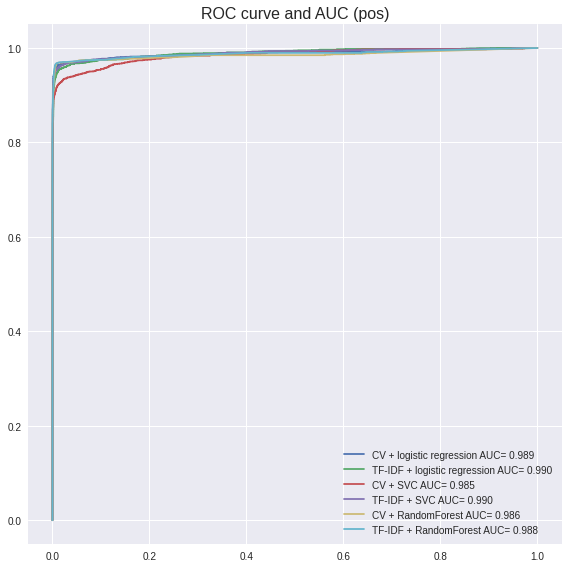

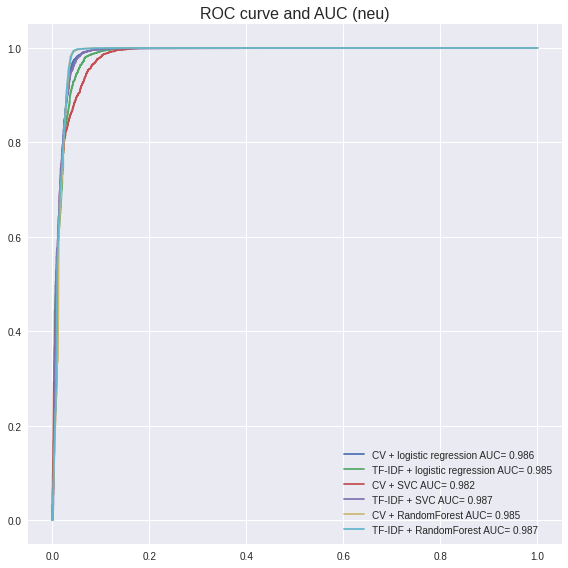

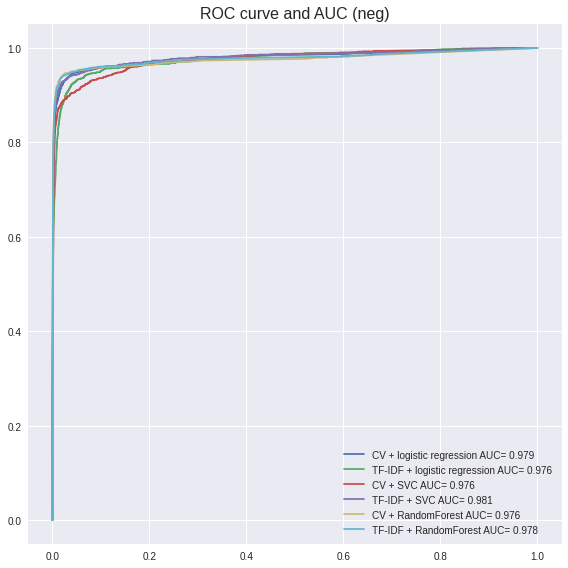

In [ ]:
plt.style.use('seaborn')    

l = ['pos','neu','neg']
for label in l:
    plt.figure(figsize =(8, 8))
    for k, v in roc_auc_all.items():
        fpr = roc_auc_all[k][label]["fpr"]
        tpr = roc_auc_all[k][label]["tpr"]
        roc_auc = roc_auc_all[k][label]["roc_auc"]
        plt.plot(fpr,tpr,label= k + " AUC= %0.3f" % roc_auc)
        plt.title('ROC curve and AUC ('+ label +')', size = 16)    
    plt.legend(loc=0)
    plt.tight_layout()

accuracy可能會因為正負面資料分布不同而有所偏差，所以選擇模型的時候，可以加入一起 AUC 評估。在這裡可以看到個模型在三種情緒的AUC指標都不會相差太多，對於AUC來說，整體而言 TF-IDF + SVC 的表現較好；而準確度為CV + RandomForest表現最好。